# PROJECTE IDENTIFICACIÓ DE VEU PER 4 PERSONES

### Introducció

Este proyecto tiene como objetivo diseñar e implementar un sistema de reconocimiento e identificación de voz para cuatro personas específicas. El sistema utilizará técnicas de procesamiento de señales de audio y aprendizaje automático para reconocer y distinguir las voces de las personas autorizadas.
El proceso de desarrollo constará de varias etapas clave. En primer lugar, se recopilarán muestras de voz de las cuatro personas de interés, abarcando una variedad de palabras y frases relevantes para el contexto de uso previsto. Estas muestras de voz se preprocesarán para extraer características acústicas relevantes, como tono, intensidad y frecuencia.
A continuación, se utilizarán algoritmos de aprendizaje automático para entrenar un modelo de reconocimiento de voz. Durante el entrenamiento, el modelo aprenderá a asociar las características acústicas de las muestras de voz con las identidades de las cuatro personas.
Una vez entrenado el modelo, se procederá a la fase de evaluación y ajuste fino. Se probará el sistema utilizando conjuntos de datos adicionales que no se utilizaron durante el entrenamiento, con el fin de evaluar su precisión y rendimiento en la identificación de las cuatro personas. Se realizarán ajustes en el modelo según sea necesario para mejorar su capacidad de reconocimiento y reducir posibles errores.


### Datos


Recopilaremos muestras de voz de cada uno de los usuarios a identificar mediante el modelo, 50 audios del tipo "hola, qué tal?" para cada uno de los usuarios a identificar, adicionalmente añadiremos 100 muestras de audio de usuarios diferentes a identificar. Por lo tanto contaremos con un total 300 audios.

|  id |  id_mensaje | audio    |   id persona |
|-----------|-----------|-----------|-----------|
| int    (0 -> 299)     |  int (01 -> 50)  |  str (path)  |  int (0 -> 5)



### Procedimiento

A paritr de los audios generados individualmente, los convertiremos en espectogramas para así convertir audios en imágenes. Los espectogramas serán las características de cada usuario a identificar. 

#### Imports

In [2]:
from pydub import AudioSegment
import time
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.optimizers import SGD, RMSprop # type: ignore

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from scipy.ndimage import gaussian_laplace
from scipy.ndimage import uniform_filter1d

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import cv2
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import describe

import threading
import speech_recognition as sr
from pydub import AudioSegment
import io
import time
import queue

import joblib
import soundfile as sf
from sklearn.metrics import confusion_matrix
import seaborn as sns


warnings.filterwarnings("ignore")

2024-05-19 16:09:35.760851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Pasar a mp3 los audios y generación de audio

In [5]:
def ajustar_duracion(audio, duracion_ms):
    """
    Ajusta la duración de un archivo de audio a una duración específica en milisegundos.
    """
    if len(audio) > duracion_ms:
        return audio[:duracion_ms]
    else:
        padding = AudioSegment.silent(duration=duracion_ms - len(audio))
        return audio + padding


In [6]:
def convertiraudiosMP3():
    '''The function `convertiraudiosMP3` converts audio files in the 'Audios' directory to MP3 format and
    prints the time taken for loading and conversion.
        
    '''
    #Convertir audios a mp3
    files = os.listdir('Audios')
    for file in files:
        if file[-3:] == ('m4a' or 'mp4') :
            try:
                audio = AudioSegment.from_file('Audios\\' + file, format=file[-3:])
                audio.export('AudiosMp3\\' + file[:-4] + ".mp3", format="mp3")
            except:
                audio = AudioSegment.from_file('Audios/' + file, format=file[-3:])
                audio.export('AudiosMp3/' + file[:-4] + ".mp3", format="mp3")

    #Convertir ruidos a mp3
    files = os.listdir('Ruidos')
    for file in files:
        if file[-3:] == ('m4a' or 'mp4') :
            try:
                audio = AudioSegment.from_file('Ruidos\\' + file, format=file[-3:])
                audio.export('RuidosMp3\\' + file[:-4] + ".mp3", format="mp3")
            except:
                audio = AudioSegment.from_file('Ruidos/' + file, format=file[-3:])
                audio.export('RuidosMp3/' + file[:-4] + ".mp3", format="mp3")




def audioGenerate():

    #Añadir ruido
    files = os.listdir('AudiosMp3') 
    ruidos = os.listdir('RuidosMp3')
    audio_ruido = AudioSegment.empty()        
        
    for ruido_file in ruidos:
            
        try:
            ruido = AudioSegment.from_file('RuidosMp3\\' + ruido_file, format="mp3")
        except:
            ruido = AudioSegment.from_file('RuidosMp3/' + ruido_file, format="mp3")
            
        for file in files:
            try:
                audio = AudioSegment.from_file('AudiosMp3\\' + file, format="mp3")
            except:
                audio = AudioSegment.from_file('AudiosMp3/' + file, format="mp3")
                    
            if audio.frame_rate != ruido.frame_rate:
                ruido = ruido.set_frame_rate(audio.frame_rate)

            ruido = ajustar_duracion(ruido, len(audio))
            audio_ruido = audio.overlay(ruido)
            try:  
                audio_ruido.export('./AudiosMp3_ruido/' + file[:-4] + '_' + ruido_file[:-4] + '.mp3', format="mp3")

            except:
                audio_ruido.export('AudiosMp3_ruido\\' + file[:-4] + '_' + ruido_file[:-4] + '.mp3', format="mp3")



In [7]:
audioGenerate()

### Funciones necesarias de metricas y preprocesado del audio

In [6]:
def average_rms():
    """
    Calculates the average root mean square (RMS) level of audio files in the 'AudiosMp3' folder.
    
    Returns:
    average_rms (float): The average RMS level of the audio files.
    """
    
    # Listar todos los archivos de audio en la carpeta
    audio_files = [os.path.join('AudiosMp3', f) for f in os.listdir('AudiosMp3') if f.endswith('.mp3')]

    # Lista para almacenar los niveles RMS de todos los audios
    rms_levels = []

    # Cargar los audios y calcular el nivel RMS
    for audio_file in audio_files:
        y, sr = librosa.load(audio_file, sr=None)
        rms = np.sqrt(np.mean(y**2))
        rms_levels.append(rms)

    # Calcular el RMS promedio
    average_rms = np.mean(rms_levels)
    
    return average_rms


In [7]:

def normalize_audio(y, target_rms):
    """
    Normalize the audio signal to a target root mean square (RMS) value.

    Parameters:
    - y (ndarray): The input audio signal.
    - target_rms (float): The desired RMS value for the normalized audio.

    Returns:
    - y_normalized (ndarray): The normalized audio signal.

    """
    current_rms = np.sqrt(np.mean(y**2))
    gain = target_rms / current_rms
    y_normalized = y * gain
    return y_normalized


def apply_compression(y, threshold=0.5, ratio=4):
    """
    Applies compression to the input signal.

    Parameters:
    - y: numpy array
        The input signal to be compressed.
    - threshold: float, optional (default=0.5)
        The threshold value for compression. Values above this threshold will be compressed.
    - ratio: int, optional (default=4)
        The compression ratio. Determines the amount of compression applied to values above the threshold.

    Returns:
    - y_compressed: numpy array
        The compressed signal.
    """
    y_compressed = np.copy(y)
    y_compressed[np.abs(y) > threshold] = threshold + (np.abs(y_compressed[np.abs(y) > threshold]) - threshold) / ratio
    return np.sign(y) * y_compressed



In [12]:
def removeSilence(audio, silence_threshold = 0.05):
    '''The `removeSilence` function removes silent segments from an audio signal based on a specified
    silence threshold.
    
    Parameters
    ----------
    audio
        The `removeSilence` function you provided is designed to remove segments of silence from an audio
    signal based on a specified silence threshold. The function takes two parameters:
    silence_threshold
        The `silence_threshold` parameter in the `removeSilence` function represents the minimum amplitude
    value below which a segment of audio is considered as silence. Any audio samples with absolute
    values less than this threshold are identified as silence and removed from the audio signal. By
    adjusting this threshold, you can control
    
    Returns
    -------
        The function `removeSilence` returns the audio signal with silence segments removed based on the
    specified silence threshold.
    
    '''
    # Encontrar los índices de los segmentos de silencio
    silence_indices = np.where(np.abs(audio) < silence_threshold)[0]

    # Crear una máscara para mantener los segmentos que no son de silencio
    mask = np.ones_like(audio, dtype=bool)
    mask[silence_indices] = False

    # Aplicar la máscara al audio para eliminar los segmentos de silencio
    audio_sin_silencio = audio[mask]

    if audio_sin_silencio.size == 0:
        return audio
    return audio_sin_silencio


In [3]:
def lowPassFilter(audio, sr, cutoff_freq = 3000):
    '''The function `lowPassFilter` applies a low-pass filter to an audio signal in the frequency domain to
    remove high-frequency components above a specified cutoff frequency.
    
    Parameters
    ----------
    audio
        The `audio` parameter is the input audio signal that you want to filter using a low-pass filter. It
    is typically represented as a one-dimensional array of audio samples.
    sr
        The `sr` parameter in the `lowPassFilter` function stands for the sampling rate of the audio
    signal. It represents the number of samples taken per second when the audio signal was recorded or
    processed. The sampling rate is typically measured in Hertz (Hz).
    cutoff_freq
        The `cutoff_freq` parameter in the `lowPassFilter` function represents the frequency at which you
    want to filter out higher frequencies from the audio signal. Frequencies above the `cutoff_freq`
    will be attenuated or removed from the signal, effectively creating a low-pass filter that allows
    only
    
    Returns
    -------
        The function `lowPassFilter` returns the filtered audio signal in the time domain after applying a
    low-pass filter in the frequency domain.
    
    '''
    y_fft = np.fft.fft(audio)

    freqs = np.fft.fftfreq(len(audio), 1 / sr)
    lowpass_filter = np.abs(freqs) <= cutoff_freq

    # Aplicar el filtro pasa bajos multiplicando la señal en el dominio de la frecuencia por el filtro
    y_fft_filtered = y_fft * lowpass_filter

    # Aplicar la Transformada Inversa de Fourier para obtener la señal filtrada en el dominio del tiempo
    y_filtered = np.real(np.fft.ifft(y_fft_filtered))
    
    return y_filtered


### Normalización del audio

In [10]:
def normalizeAudios():
    normalized_folder = 'AudiosMp3_norm'
    os.makedirs(normalized_folder, exist_ok=True)

    audio_files = [os.path.join('AudiosMp3', f) for f in os.listdir('AudiosMp3') if f.endswith('.mp3')]

    for audio_file in audio_files:
        y, sr = librosa.load(audio_file, sr=None)

        y = normalize_audio(y, average_rms())
        y = lowPassFilter(y, sr)
        y = apply_compression(y)

        output_file = os.path.join(normalized_folder, os.path.basename(audio_file))
        sf.write(output_file, y, sr)



In [4]:
def plot_confusion_matrix(y_true, y_pred, classes = 5, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues, save_path = None):
    """
    Plots the confusion matrix for a given set of true labels and predicted labels.

    Parameters:
    - y_true (array-like): The true labels.
    - y_pred (array-like): The predicted labels.
    - classes (int or array-like, optional): The number of classes or the class labels. Default is 5.
    - normalize (bool, optional): Whether to normalize the confusion matrix. Default is False.
    - title (str, optional): The title of the plot. Default is 'Confusion Matrix'.
    - cmap (matplotlib colormap, optional): The colormap to be used in the plot. Default is plt.cm.Blues.

    Returns:
    None
    """
    
    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalizar si es necesario
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    print(cm)

    # Crear el plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap)
    
    
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    
    
    
        # Guardar el plot si se proporciona un save_path
    if save_path:
        plt.savefig(save_path, format='png')
        print(f"El gráfico ha sido guardado como {save_path}")
        
    plt.show()
    



#### Creación Dataset

In [5]:
def createDataset(directoryName = 'original'):
    '''The function creates a dataset from audio files in a directory, extracting message ID, audio file
    name, and person ID.
    
    Returns
    -------
        A DataFrame containing information about audio files in the 'AudiosMp3' directory. The DataFrame
    has columns 'Id_Mensaje', 'Audio', and 'Id_Persona'.
    
    '''
    
    
    if directoryName == 'ruidoNorm':
        filesMp3 = os.listdir('AudiosMp3_norm')
    elif directoryName == 'ruido':
        filesMp3 = os.listdir('AudiosMp3_ruido')
    else:
        filesMp3 = os.listdir('AudiosMp3')

        

    dict = {'Id_Mensaje': [], 'Audio': [], 'Id_Persona': []}
    for file in filesMp3:
        dict['Id_Mensaje'].append(int(file.split('_')[0]))
        dict['Audio'].append(file)
        name = file.split('_')[1]
        if 'Gerard' in name: 
            dict['Id_Persona'].append(0)
        elif 'Albert' in name: 
            dict['Id_Persona'].append(1)
        elif 'Adria' in name: 
            dict['Id_Persona'].append(2)
        elif 'Raul' in name: 
            dict['Id_Persona'].append(3)
        else:
            dict['Id_Persona'].append(4) 
            
    return pd.DataFrame(dict)

df = createDataset()
df

,Id_Mensaje,Audio,Id_Persona
0,33,33_Albert.mp3,1
1,4,04_Albert.mp3,1
2,29,29_Adria.mp3,2
3,48,48_Jessi.mp3,4
4,47,47_Adria.mp3,2
...,...,...,...
217,21,21_Adria.mp3,2
218,21,21_Gerard.mp3,0
219,14,14_Adria.mp3,2
220,36,36_Raul.mp3,3


#### Visualizar audios

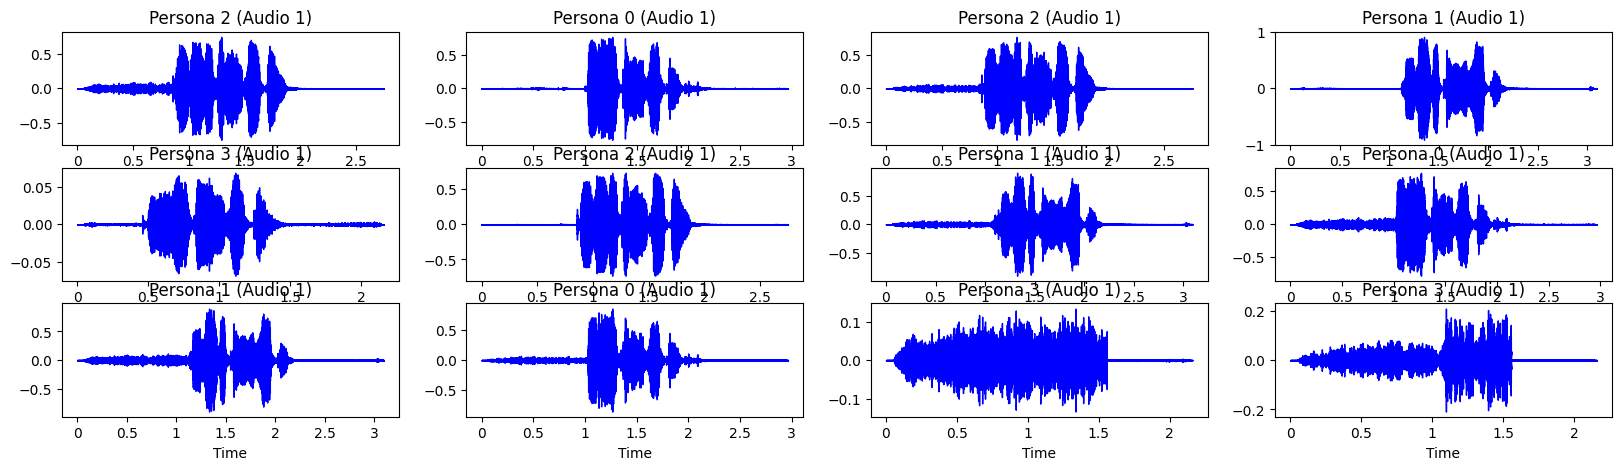

In [ ]:
def visualizeAudio(nAudio):
  '''The function `visualizeAudio` takes an audio ID as input, retrieves corresponding audio files from a
  DataFrame, and displays waveforms of the audio files in a subplot.
      
  Parameters
  ----------
  nAudio
  It looks like you have provided a code snippet for visualizing audio data from a DataFrame based on
  a specific audio ID. The `visualizeAudio` function takes an audio ID (`nAudio`) as input and then
  plots the waveforms of the corresponding audio files.
      
  '''
  
  audios = df[df['Id_Mensaje'] == nAudio]

  audios = audios.reset_index()
  fig, ax = plt.subplots(3, len(audios)//3, figsize=(20, 5))
  i = 0
  j = 0
  for index, row in audios.iterrows():
        # Cargar el archivo de audio MP3
      try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
      except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
        
      librosa.display.waveshow(y ,sr=sr, ax=ax[i, j], color="blue")
      ax[i , j].set_title('Persona ' + str(row['Id_Persona']) + ' (Audio ' + str(nAudio) + ')')
      
      j = j +1
      
      if j >= len(audios)//3:
        j = 0
        i= i + 1
  plt.show()

visualizeAudio(1)
    


In [ ]:
def fft_plot(y, sr, persona, nAudio, ax):
    '''The function `fft_plot` calculates the Fast Fourier Transform of an audio signal and plots the
    frequency spectrum.
    
    Parameters
    ----------
    y
        The parameter "y" in the function `fft_plot` is typically the input signal that you want to analyze
    using the Fast Fourier Transform (FFT). This signal is usually a time-domain audio signal
    represented as a one-dimensional array of amplitude values.
    sr
        The parameter `sr` in the `fft_plot` function represents the sampling rate of the audio signal `y`.
    It indicates how many samples of the signal are taken per second.
    persona
        It seems like you were about to ask for an explanation of the `persona` parameter in your
    `fft_plot` function. The `persona` parameter likely represents a specific person or entity
    associated with the audio data being analyzed. It could be used to differentiate between different
    individuals or sources of audio data when
    nAudio
        It seems like the explanation for the parameter `nAudio` is missing in the provided code snippet.
    Could you please provide more information or context about the `nAudio` parameter so that I can
    assist you better?
    ax
        The `ax` parameter in the `fft_plot` function is typically used to pass a Matplotlib Axes object,
    which represents a subplot where the FFT plot will be displayed. This allows you to plot the FFT
    graph on a specific subplot within a larger figure, giving you more control over the layout of
    
    '''
    n = len(y)
    T = 1/sr
    yf = np.fft.fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
    ax.grid()
    ax.set_title("Rang de Frequencies Persona " + str(persona) + " (Audio " + str(nAudio) +")")
    ax.set_xlabel("Frequencia")
    ax.set_ylabel("Magnitud")
    c = yf[:n//2]

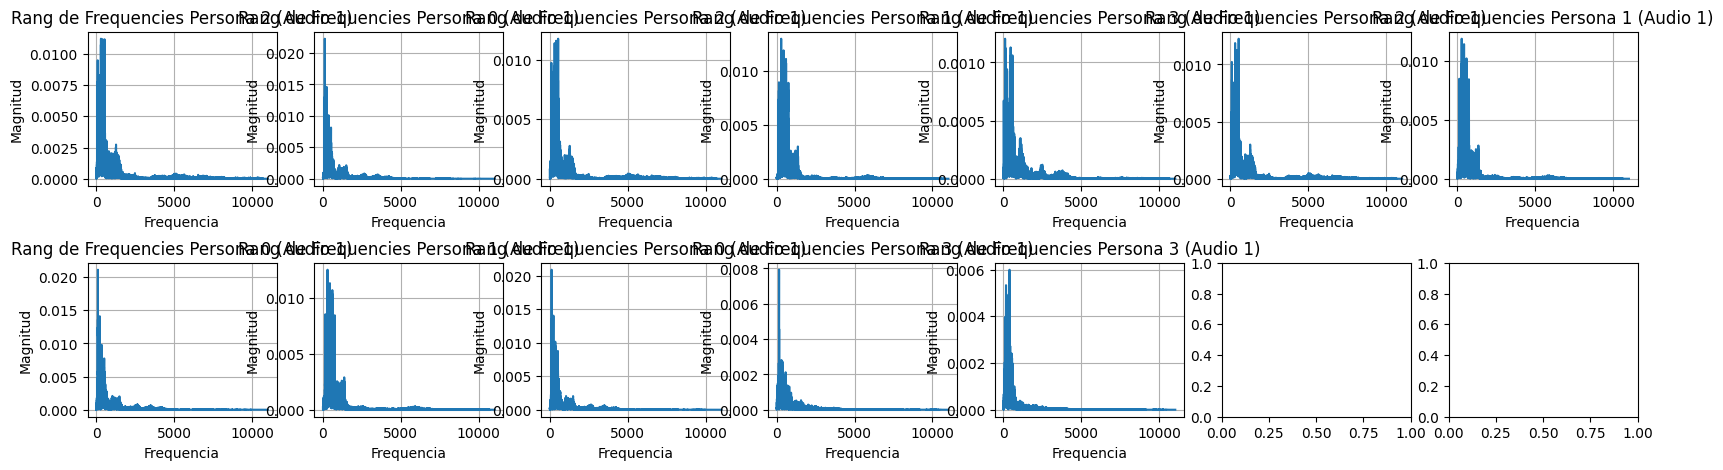

In [ ]:
def visualizeFFT(nAudio):
  '''The function `visualizeFFT` takes an audio ID as input, retrieves corresponding audio files, loads
  them, and plots their Fast Fourier Transform (FFT) using matplotlib and librosa.
        
  Parameters
  ----------
  nAudio
  It looks like the `visualizeFFT` function is designed to visualize the Fast Fourier Transform (FFT)
  of audio files. The `nAudio` parameter seems to represent the ID of the audio message you want to
  visualize.
    
  '''
  audios = df[df['Id_Mensaje'] == nAudio]
  audios = audios.reset_index()
  fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
  i = 0
  j = 0
  for index, row in audios.iterrows():
        # Cargar el archivo de audio MP3
      try:
        y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
      except:
        y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
      fft_plot(y, sr, row['Id_Persona'], nAudio, ax[i, j])
      j = j + 1
      if j == int(len(audios)/2) + 1:
          j = 0
          i = i + 1
  plt.subplots_adjust(hspace=0.5)  # Ajustar el espacio vertical entre subgráficos
          
visualizeFFT(1)

#### Familiarització amb espectogrames

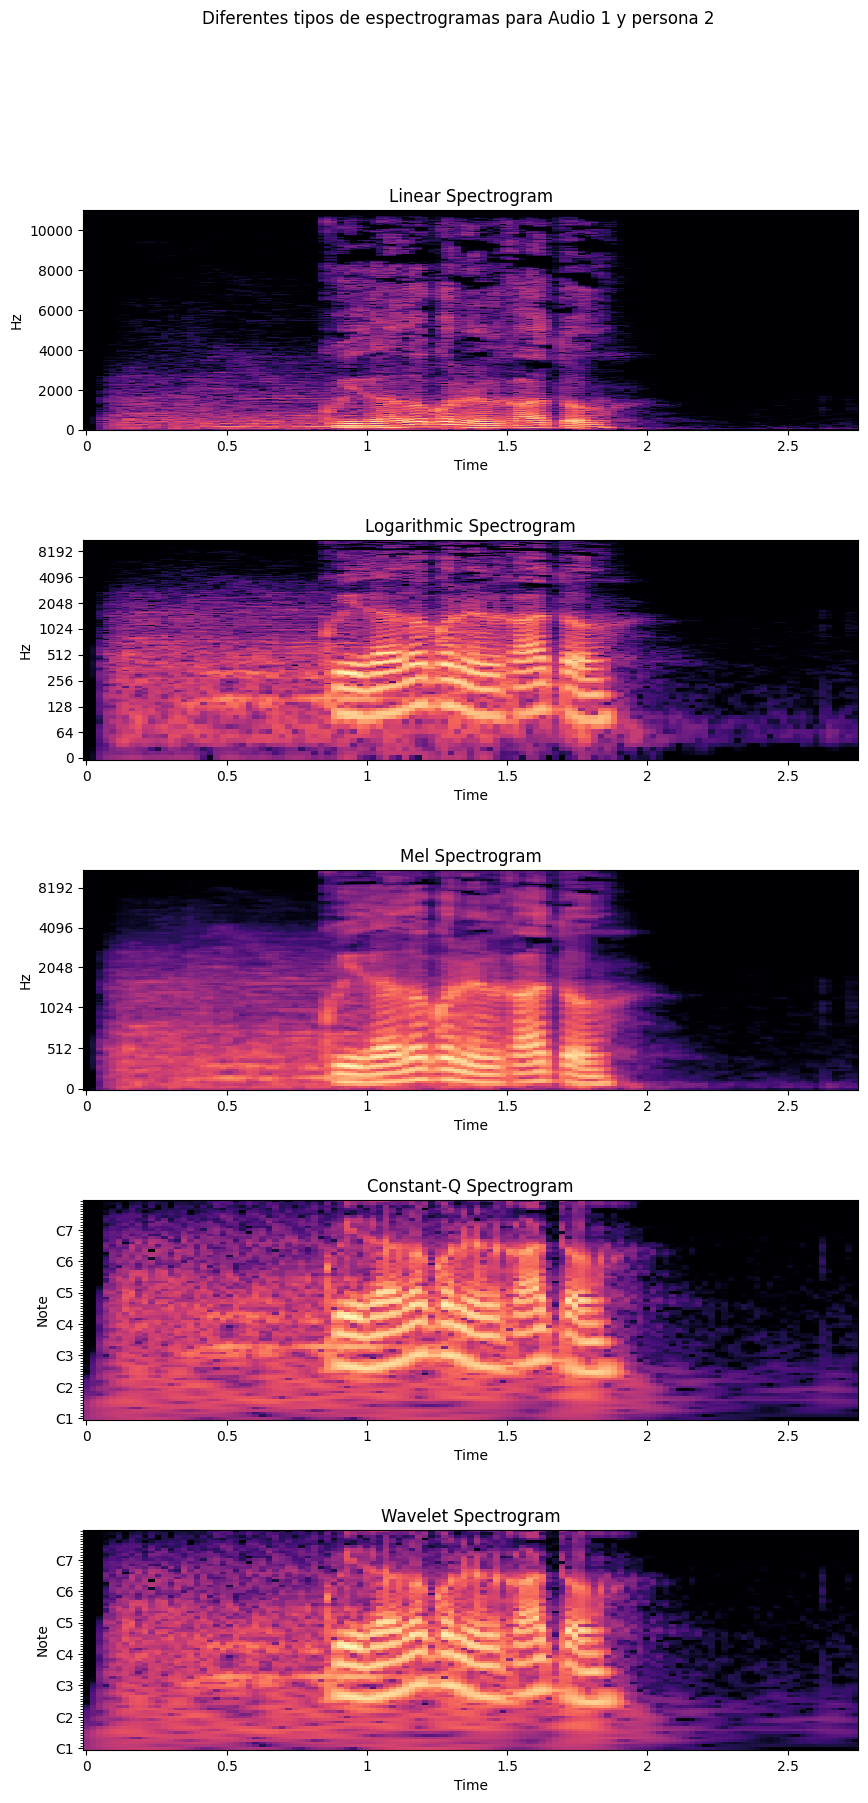

In [ ]:
def visualzeSpectograms(nAudio):
    '''The function `visualzeSpectograms` generates and displays different types of spectrograms for a
    given audio file and person ID.
    
    Parameters
    ----------
    nAudio
        The function `visualzeSpectograms(nAudio)` is designed to visualize different types of spectrograms
    for a given audio file. The parameter `nAudio` represents the ID of the audio file for which you
    want to generate and display the spectrograms.
    
    '''
    
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))

    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()

    audio = audios.iloc[0]
    try:
        y, sr = librosa.load(f"AudiosMp3\\{audio['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{audio['Audio']}")
    
    
    
    
    linear_spec = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(linear_spec, ref=np.max), ax=axs[0], sr=sr, x_axis='time', y_axis='linear')
    axs[0].set_title('Linear Spectrogram')

    log_spec = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(log_spec, ref=np.max), ax=axs[1], sr=sr, x_axis='time', y_axis='log')
    axs[1].set_title('Logarithmic Spectrogram')

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), ax=axs[2], sr=sr, x_axis='time', y_axis='mel')
    axs[2].set_title('Mel Spectrogram')

    cqt_spec = np.abs(librosa.cqt(y, sr=sr))
    librosa.display.specshow(librosa.amplitude_to_db(cqt_spec, ref=np.max), ax=axs[3], sr=sr, x_axis='time', y_axis='cqt_note')
    axs[3].set_title('Constant-Q Spectrogram')

    wavelet_spec = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1')))
    librosa.display.specshow(librosa.amplitude_to_db(wavelet_spec, ref=np.max), ax=axs[4], sr=sr, x_axis='time', y_axis='cqt_note')
    axs[4].set_title('Wavelet Spectrogram')

    fig.suptitle('Diferentes tipos de espectrogramas para Audio ' + str(nAudio) + ' y persona ' + str(audio['Id_Persona']))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
     
visualzeSpectograms(1)

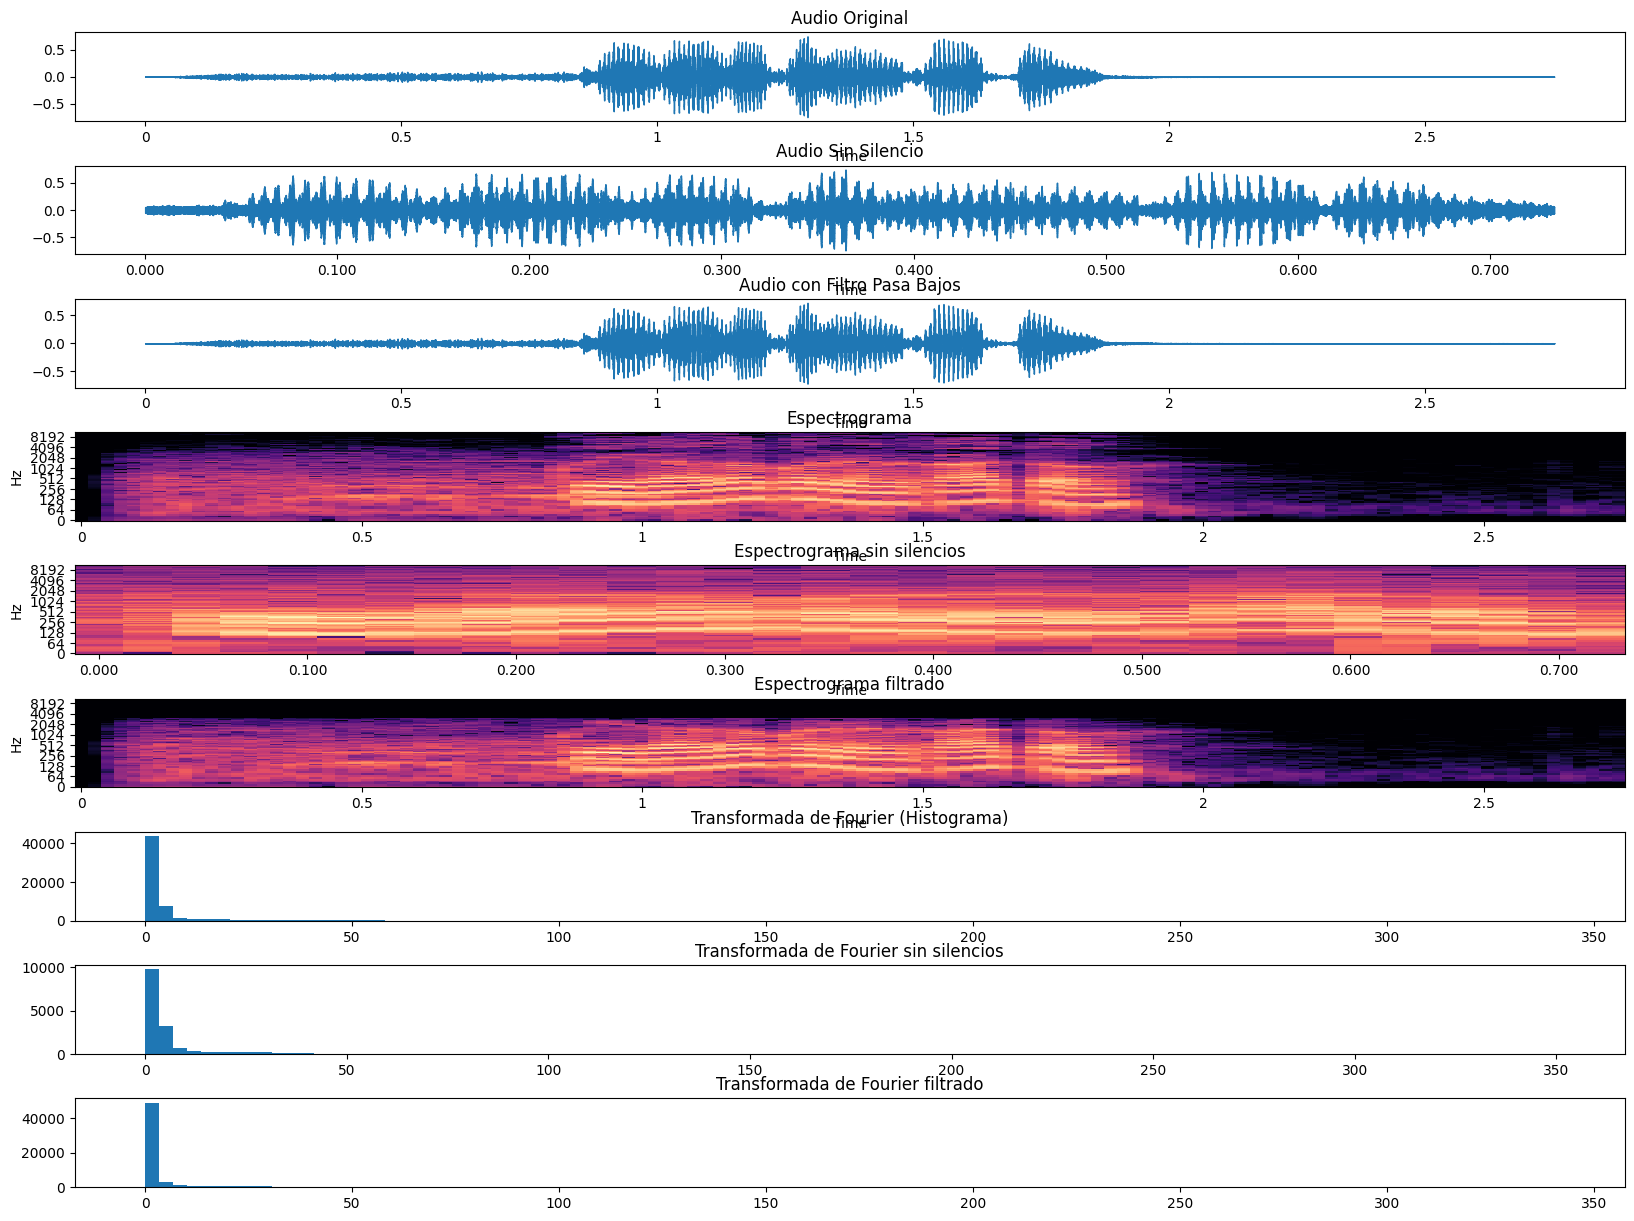

In [ ]:
def visualizeAll( nAudio):
    '''The function `visualize_audio` takes an audio ID, loads the audio file, applies various audio
    processing techniques, and visualizes the original audio, filtered audio, spectrograms, and Fourier
    transforms.
    
    Parameters
    ----------
    nAudio
        It seems like the `visualize_audio` function is designed to visualize different aspects of audio
    data stored in a DataFrame based on the provided `nAudio` identifier. The function loads audio
    files, processes them, and displays various visualizations such as waveforms, spectrograms, and
    Fourier transforms.
    
    '''
    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()
    
    i = 0
        
    audio = audios.iloc[i]
    
    fig, ax = plt.subplots(9,1, figsize=(20, 15))
    try:
            # Cargar el archivo de audio MP3
        y, sr = librosa.load(f"AudiosMp3\\{audio['Audio']}")
    except:
        y, sr = librosa.load(f"AudiosMp3/{audio['Audio']}")

    # Visualizar el audio original
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_title('Audio Original')
        
    # Eliminar silencios
    y_sin_silencio = removeSilence(y)
    librosa.display.waveshow(y_sin_silencio, sr=sr, ax=ax[1])
    ax[1].set_title('Audio Sin Silencio')

    # Aplicar filtro pasa bajos
    y_filtrado = lowPassFilter(y, sr)
    librosa.display.waveshow(y_filtrado, sr=sr, ax=ax[2])
    ax[2].set_title('Audio con Filtro Pasa Bajos')

    # Espectrograma
    D = np.abs(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[3], x_axis='time', y_axis='log')
    ax[3].set_title('Espectrograma')
        
    # Espectrograma sin silencio
    D = np.abs(librosa.stft(y_sin_silencio))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[4], x_axis='time', y_axis='log')
    ax[4].set_title('Espectrograma sin silencios')
        
    # Espectrograma filtrado
    D = np.abs(librosa.stft(y_filtrado))
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, ax=ax[5], x_axis='time', y_axis='log')
    ax[5].set_title('Espectrograma filtrado')
        

    # Transformada de Fourier (en forma de histograma)
    y_fft = np.fft.fft(y)
    ax[6].hist(np.abs(y_fft), bins=100)
    ax[6].set_title('Transformada de Fourier (Histograma)')
        
    # Transformada de Fourier sin silencios
    y_fft = np.fft.fft(y_sin_silencio)
    ax[7].hist(np.abs(y_fft), bins=100)
    ax[7].set_title('Transformada de Fourier sin silencios')
        
    # Transformada de Fourier filtrado
    y_fft = np.fft.fft(y_filtrado)
    ax[8].hist(np.abs(y_fft), bins=100)
    ax[8].set_title('Transformada de Fourier filtrado')
        
    plt.subplots_adjust(hspace=0.5)

    plt.show()

visualizeAll(1)

## Modelos de identificación de voz

###  El primer model (Logistic regression amb 15 característiques extretes de librosa.feature)

In [11]:
def extract_features(y, sr):
    '''The function `extract_features` calculates various audio features from a given audio signal using
    the librosa library and returns them as a list.
    
    Parameters
    ----------
    y
        The parameter `y` in the `extract_features` function represents the audio time series. It is the
    audio signal as a one-dimensional NumPy array.
    sr
        The `sr` parameter in the `extract_features` function stands for the sampling rate of the audio
    signal. It represents the number of samples of audio carried per second, typically measured in Hz
    (Hertz). It is an important parameter in audio processing as it determines the quality and fidelity
    of the audio
    
    Returns
    -------
        The function `extract_features` returns a list of mean values of various audio features extracted
    using Librosa library functions. The features include chroma_stft, spectral centroid, spectral
    bandwidth, spectral rolloff, zero crossing rate, spectral flatness, and root mean square (RMS)
    energy.
    
    '''
    features = []
    features.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
    features.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    features.append(np.mean(librosa.feature.spectral_flatness(y=y)))
    features.append(np.mean(librosa.feature.rms(y=y)))
  
    
    return features


In [12]:
def compute_row(row, dataType, silence = False, filter = False):
    '''The function `compute_row` loads an audio file, extracts features from it, and returns the features
    along with the corresponding person ID.
    
    Parameters
    ----------
    row
        The `row` parameter in the `compute_row` function represents a single row of data from a DataFrame.
    In this case, it seems like the DataFrame `df` contains information about audio files, and each row
    corresponds to a specific audio file entry.
    
    Returns
    -------
        The code is returning a DataFrame `data` that contains the features extracted from audio files in
    the DataFrame `df`. Each row in the DataFrame `data` contains the features extracted from an audio
    file along with the corresponding 'Id_Persona' from the original DataFrame `df`.
    
    '''
    
    if dataType == 'original':
        directory = 'AudiosMp3'
    elif dataType == 'ruido':
        directory = 'AudiosMp3_ruido'
    elif dataType == 'ruidoNorm':
        directory = 'AudiosMp3_norm'

    try:
        y, sr = librosa.load(f"{directory}\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"{directory}/{row['Audio']}")
    # Replace this with your feature extraction code

    if silence:
        try: 
            y = removeSilence(y)
        except: 
            print("Error al eliminar silencios")

    if filter: y = lowPassFilter(y, sr)

    features = extract_features(y, sr)
    
    return features, row['Id_Persona']




In [6]:
def unzipData(data):
    '''The `unzipData` function takes a list of tuples, separates the elements into two arrays, and returns
    them.
    
    Parameters
    ----------
    data
        The `data` parameter is expected to be a list of tuples where each tuple contains two elements. The
    first element should be the input data (X) and the second element should be the corresponding target
    data (y).
    
    Returns
    -------
        The `unzipData` function returns two arrays, `X` and `y`, after unzipping the input `data` and
    converting them into numpy arrays.
    
    '''
    X, y = zip(*data)
    X = np.array(list(X))
    y =np.array(list(y))
    return X, y



In [14]:
def backtestFeaturesModel(dataType = 'original'):
    '''The `backtest` function performs a machine learning backtesting process on a given DataFrame,
    testing different models with various preprocessing techniques and storing the results in a
    DataFrame.
    
    Parameters
    ----------
    df
        The `backtest` function you provided seems to be performing a machine learning model evaluation
    process on a given DataFrame `df`. It iterates over different combinations of preprocessing methods
    and models to evaluate their performance using accuracy as the metric.
    
    Returns
    -------
        The function `backtest(df)` returns a pandas DataFrame containing the results of testing different
    machine learning models (SVM, Logistic Regression, Random Forest) with different preprocessing
    methods (No preprocessing, StandardScaler) on the input data `df`. The DataFrame includes columns
    for the model used, the preprocessing method applied, and the accuracy score achieved by each model
    during testing.
    
    '''
    
    results = []
    df = createDataset(dataType)
    
    for filterAudio in [True, False]:
        for silenceAudio in [False]:
            data = df.apply(lambda row: compute_row(row,dataType=dataType, filter=filterAudio, silence=silenceAudio), axis=1)
                
            X, y = unzipData(data)
                    
            sc = StandardScaler()        # Guardar el modelo y el normalizador
            X = sc.fit_transform(X)
            joblib.dump(sc, f'./modelos/{dataType}/featureModel/scalers/scaler_featureModel_filter_{str(filterAudio)}.pkl')
    
            for model, modelName in [ (SVC(), 'svc'),  (LogisticRegression(), 'lr'), (RandomForestClassifier(), 'rf')]:

                print(f"Model {str(model)} - filter: {str(filterAudio)} - silence: {str(silenceAudio)}")

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
                
                t0 = time.time()
                model.fit(X_train, y_train)
                        
                joblib.dump(model, f'./modelos/{dataType}/featureModel/modelos/{modelName}_featureModel_filter_{str(filterAudio)}.pkl')
    
                t1 = time.time() - t0
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                plot_confusion_matrix(y_test, y_pred, title=f'confusion matrix, filter - {filterAudio}, model - {modelName}', save_path=f'./modelos/{dataType}/featureModel/cm/filter_{str(filterAudio)}_model_{modelName}.png')
                
                results.append({
                    'Model': modelName,
                    'silence': str(silenceAudio),
                    'filter': str(filterAudio),   
                    'Accuracy': accuracy,
                    'time' : t1,
                                    
                })
                
                    

    return pd.DataFrame(results)



Model SVC() - filter: True - silence: False
Matriz de confusión normalizada
[[1.  0.  0.  0.  0. ]
 [0.2 0.6 0.2 0.  0. ]
 [0.2 0.3 0.5 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.8 0.  0.  0.  0.2]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_True_model_svc.png


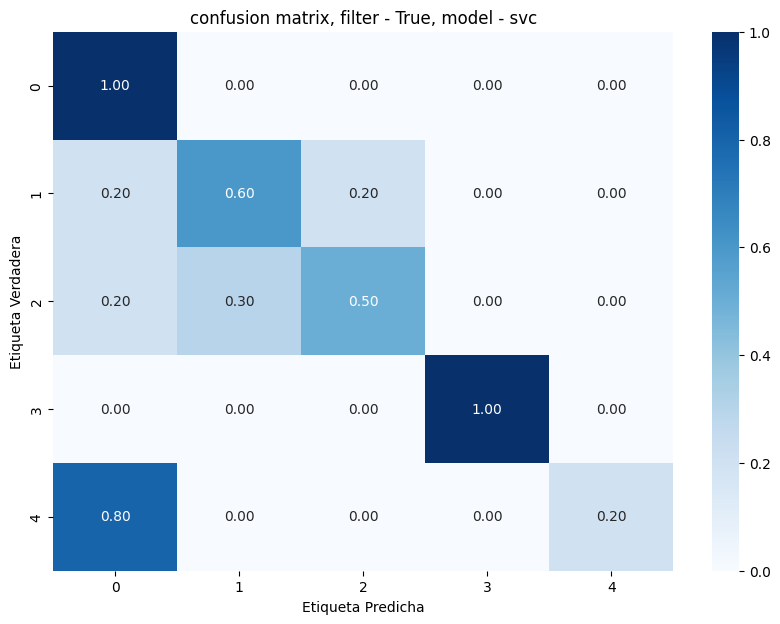

Model LogisticRegression() - filter: True - silence: False
Matriz de confusión normalizada
[[0.9 0.  0.1 0.  0. ]
 [0.  0.6 0.4 0.  0. ]
 [0.1 0.3 0.6 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.8 0.  0.  0.  0.2]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_True_model_lr.png


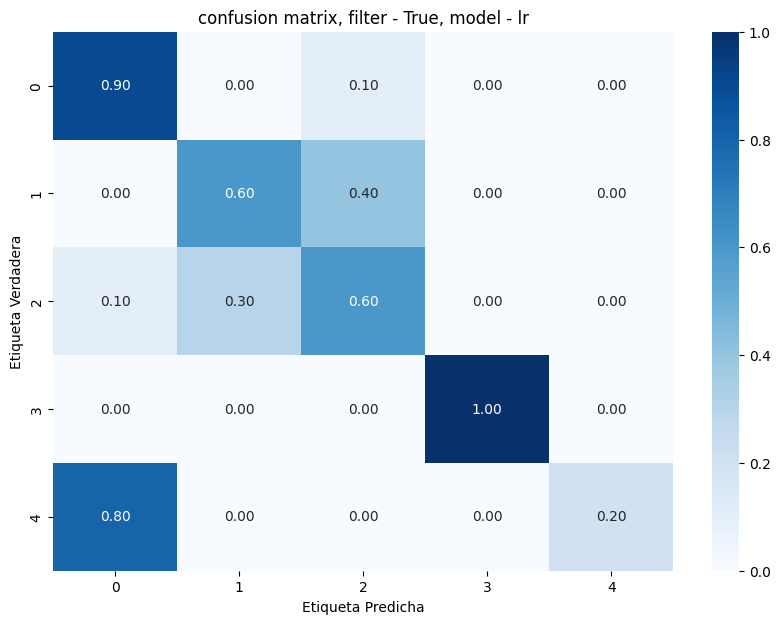

Model RandomForestClassifier() - filter: True - silence: False
Matriz de confusión normalizada
[[0.9 0.  0.  0.1 0. ]
 [0.1 0.5 0.4 0.  0. ]
 [0.2 0.3 0.5 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [1.  0.  0.  0.  0. ]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_True_model_rf.png


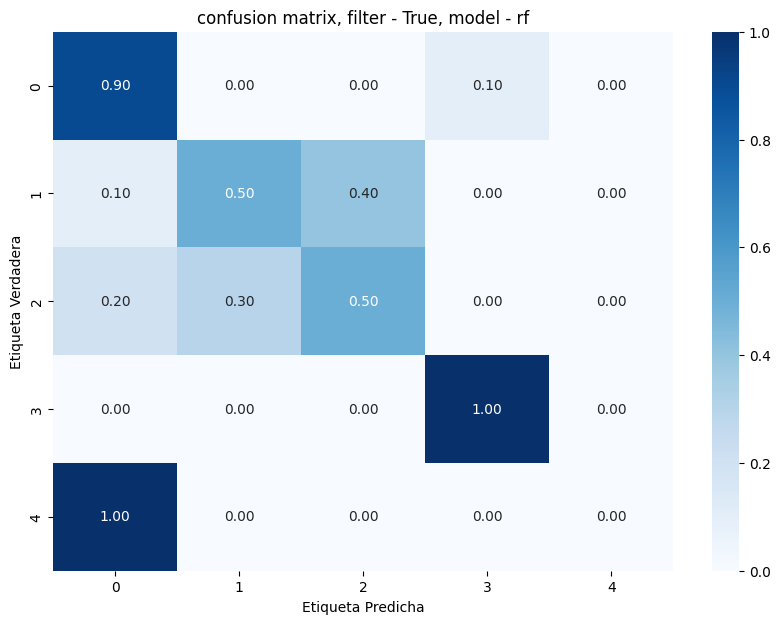

Model SVC() - filter: False - silence: False
Matriz de confusión normalizada
[[1.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.1 0.9 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.2 0.  0.8]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_False_model_svc.png


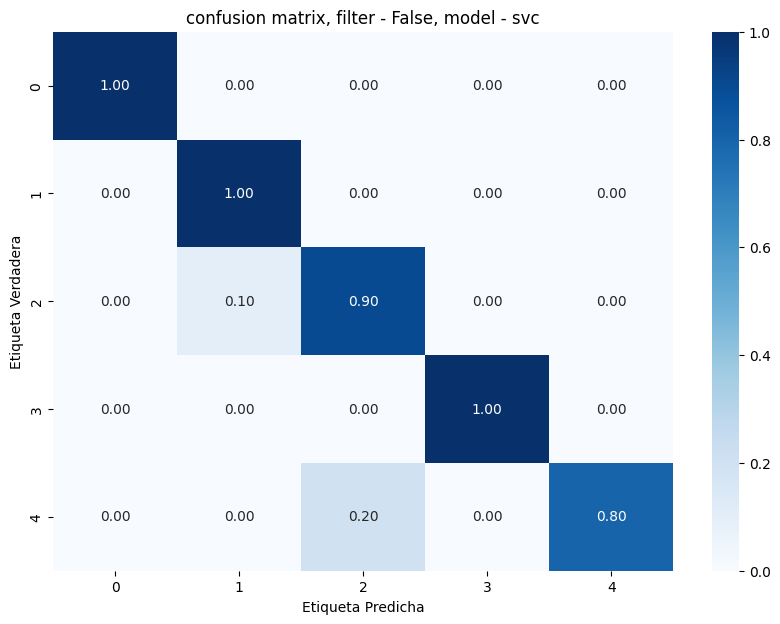

Model LogisticRegression() - filter: False - silence: False
Matriz de confusión normalizada
[[1.  0.  0.  0.  0. ]
 [0.  0.8 0.2 0.  0. ]
 [0.  0.1 0.9 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.2 0.  0.8]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_False_model_lr.png


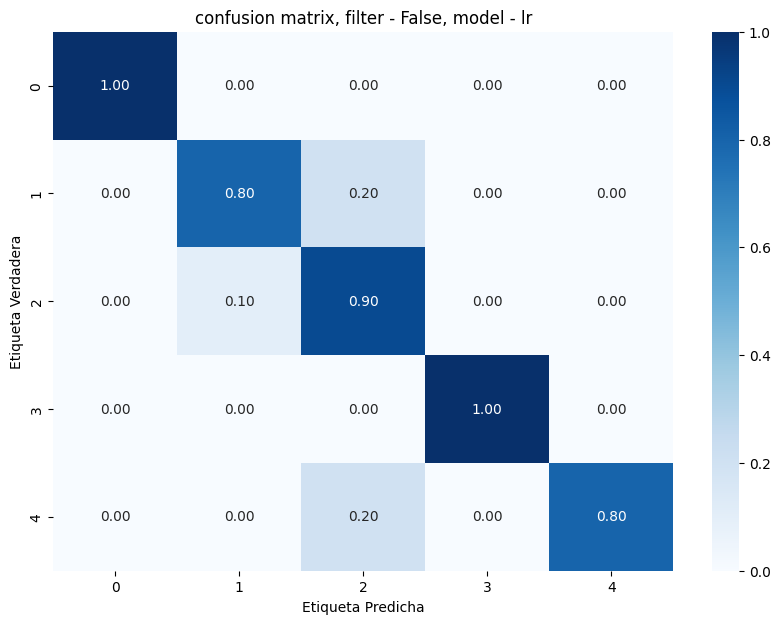

Model RandomForestClassifier() - filter: False - silence: False
Matriz de confusión normalizada
[[0.7 0.  0.  0.1 0.2]
 [0.  1.  0.  0.  0. ]
 [0.  0.1 0.8 0.  0.1]
 [0.  0.  0.  1.  0. ]
 [0.2 0.  0.  0.  0.8]]
El gráfico ha sido guardado como ./modelos/original/featureModel/cm/filter_False_model_rf.png


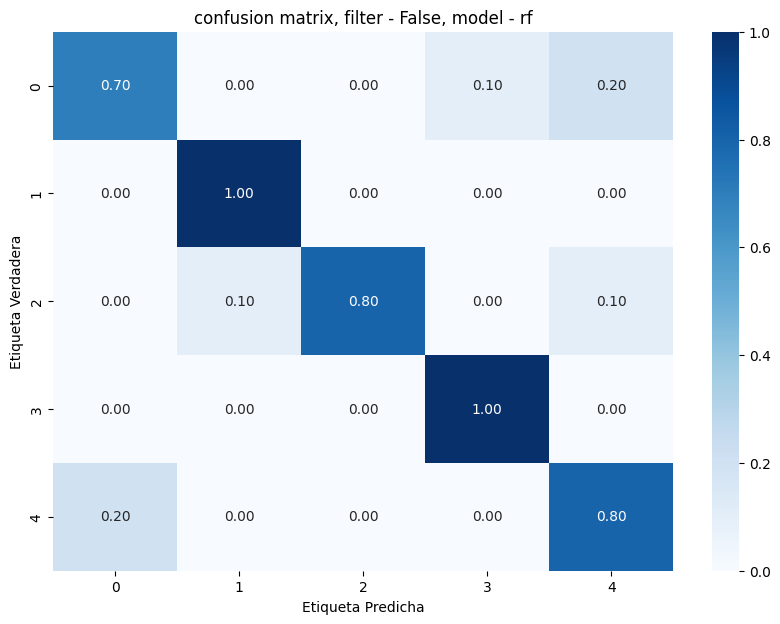

,Model,silence,filter,Accuracy,time
3,svc,False,False,0.955556,0.004626
4,lr,False,False,0.911111,0.006846
5,rf,False,False,0.866667,0.189761
0,svc,False,True,0.711111,0.004990
1,lr,False,True,0.711111,0.010320
2,rf,False,True,0.644444,0.185601


In [17]:
results_original = backtestFeaturesModel()
results_original = results_original.sort_values(by='Accuracy', ascending=False)
results_original    

Model SVC() - filter: True - silence: False
Matriz de confusión normalizada
[[0.8        0.         0.08       0.12       0.        ]
 [0.12       0.66       0.2        0.02       0.        ]
 [0.24       0.04       0.72       0.         0.        ]
 [0.06       0.         0.         0.94       0.        ]
 [0.45454545 0.         0.09090909 0.09090909 0.36363636]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_True_model_svc.png


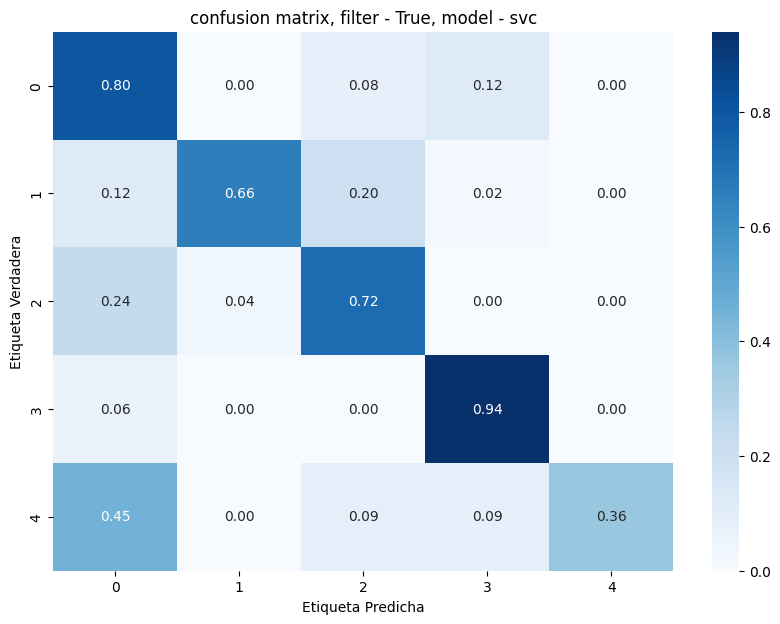

Model LogisticRegression() - filter: True - silence: False
Matriz de confusión normalizada
[[0.74       0.02       0.04       0.16       0.04      ]
 [0.06       0.66       0.24       0.04       0.        ]
 [0.26       0.08       0.64       0.         0.02      ]
 [0.06       0.04       0.         0.8        0.1       ]
 [0.31818182 0.04545455 0.         0.18181818 0.45454545]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_True_model_lr.png


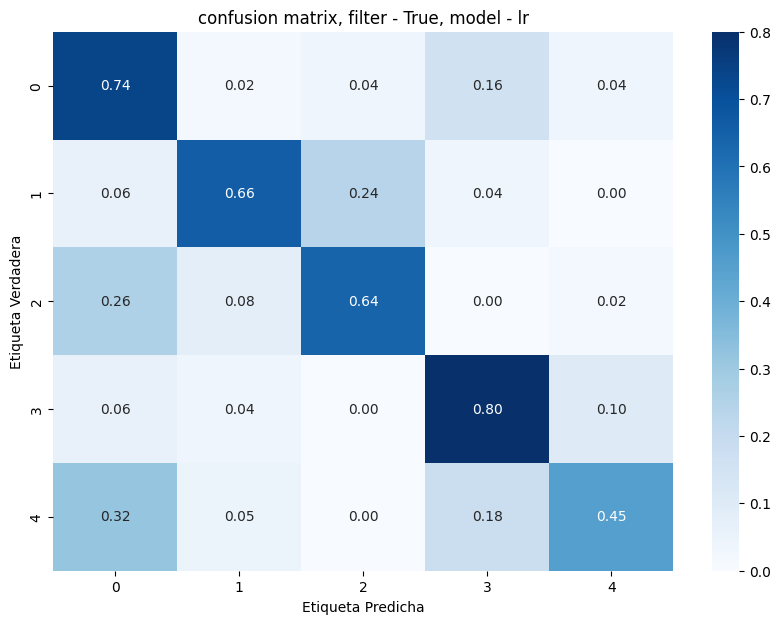

Model RandomForestClassifier() - filter: True - silence: False
Matriz de confusión normalizada
[[0.72       0.02       0.08       0.04       0.14      ]
 [0.14       0.62       0.2        0.04       0.        ]
 [0.24       0.1        0.66       0.         0.        ]
 [0.1        0.         0.         0.9        0.        ]
 [0.31818182 0.         0.09090909 0.04545455 0.54545455]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_True_model_rf.png


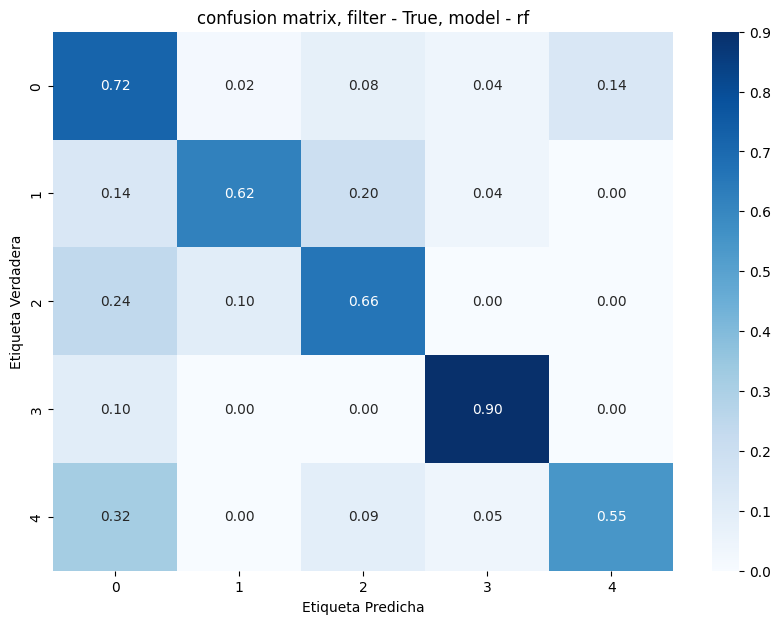

Model SVC() - filter: False - silence: False
Matriz de confusión normalizada
[[0.9        0.         0.         0.1        0.        ]
 [0.02       0.88       0.08       0.         0.02      ]
 [0.         0.06       0.92       0.         0.02      ]
 [0.04       0.         0.         0.9        0.06      ]
 [0.04545455 0.04545455 0.09090909 0.         0.81818182]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_False_model_svc.png


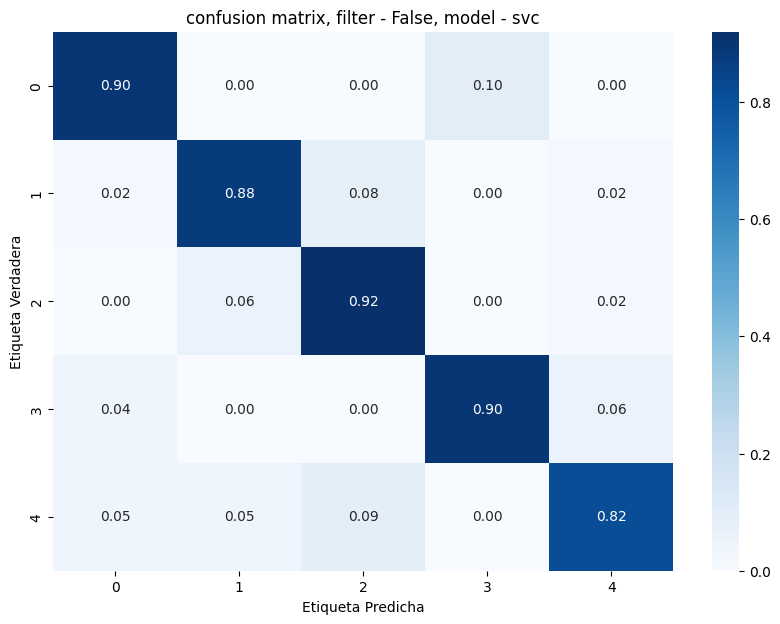

Model LogisticRegression() - filter: False - silence: False
Matriz de confusión normalizada
[[0.86       0.         0.         0.14       0.        ]
 [0.         0.96       0.02       0.         0.02      ]
 [0.         0.04       0.94       0.         0.02      ]
 [0.12       0.         0.         0.8        0.08      ]
 [0.09090909 0.13636364 0.09090909 0.04545455 0.63636364]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_False_model_lr.png


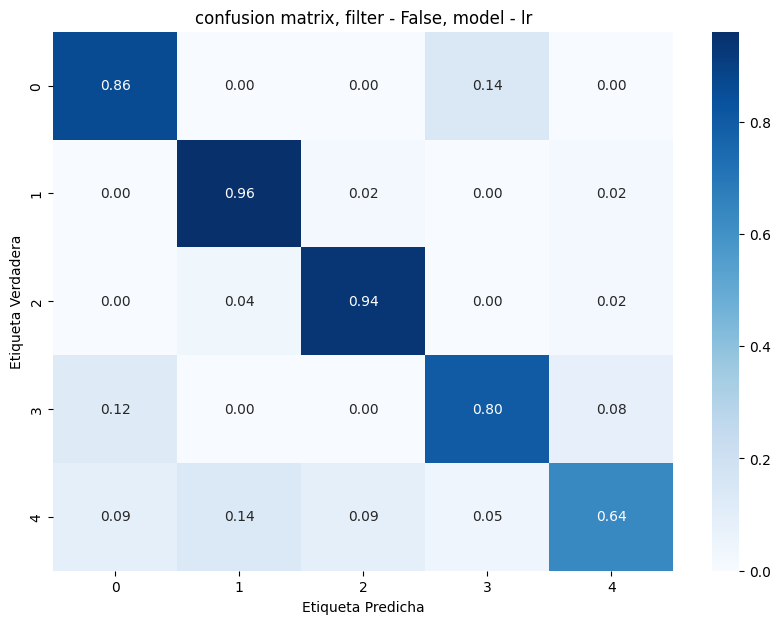

Model RandomForestClassifier() - filter: False - silence: False
Matriz de confusión normalizada
[[0.92       0.         0.         0.08       0.        ]
 [0.02       0.84       0.08       0.02       0.04      ]
 [0.         0.1        0.88       0.         0.02      ]
 [0.08       0.         0.         0.9        0.02      ]
 [0.04545455 0.09090909 0.09090909 0.         0.77272727]]
El gráfico ha sido guardado como ./modelos/ruido/featureModel/cm/filter_False_model_rf.png


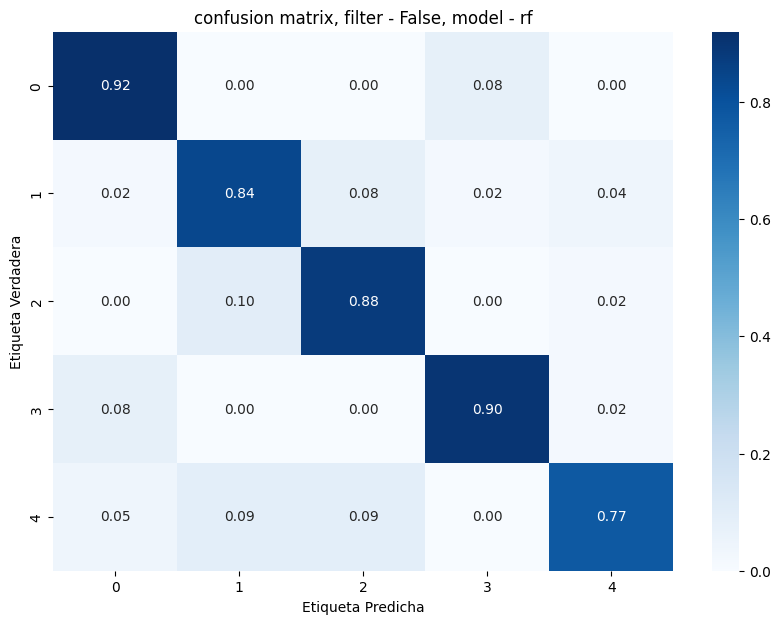

,Model,silence,filter,Accuracy,time
3,svc,False,False,0.891892,0.014458
5,rf,False,False,0.873874,0.609675
4,lr,False,False,0.864865,0.016380
0,svc,False,True,0.738739,0.034064
2,rf,False,True,0.707207,0.416230
1,lr,False,True,0.684685,0.054070


In [16]:
results_ruido = backtestFeaturesModel(dataType='ruido')
results_ruido = results_ruido.sort_values(by='Accuracy', ascending=False)
results_ruido

Model SVC() - filter: True - silence: False
Matriz de confusión normalizada
[[0.58333333 0.2        0.1        0.1        0.01666667]
 [0.15       0.71666667 0.06666667 0.06666667 0.        ]
 [0.05       0.18333333 0.76666667 0.         0.        ]
 [0.11666667 0.05       0.03333333 0.78333333 0.01666667]
 [0.2962963  0.25925926 0.18518519 0.11111111 0.14814815]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_True_model_svc.png


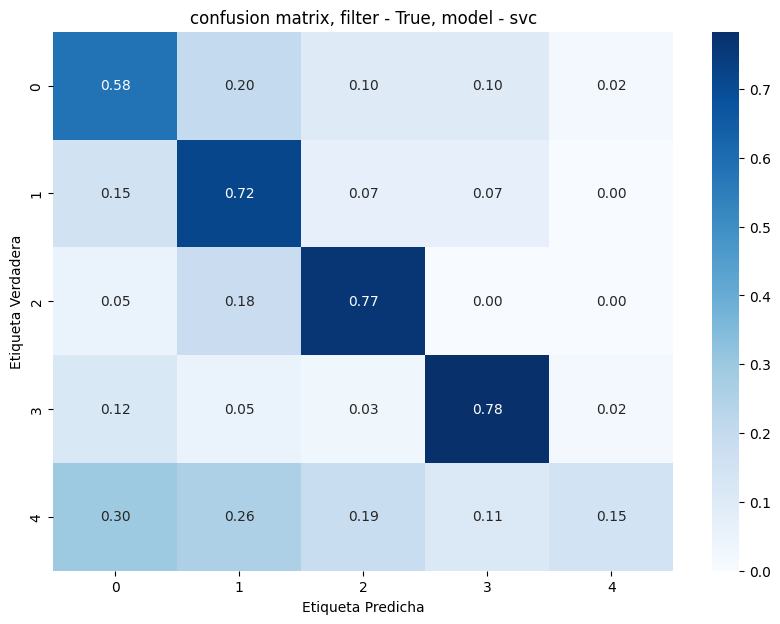

Model LogisticRegression() - filter: True - silence: False
Matriz de confusión normalizada
[[0.61666667 0.06666667 0.11666667 0.2        0.        ]
 [0.26666667 0.51666667 0.08333333 0.13333333 0.        ]
 [0.08333333 0.08333333 0.78333333 0.05       0.        ]
 [0.26666667 0.13333333 0.03333333 0.51666667 0.05      ]
 [0.18518519 0.18518519 0.40740741 0.18518519 0.03703704]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_True_model_lr.png


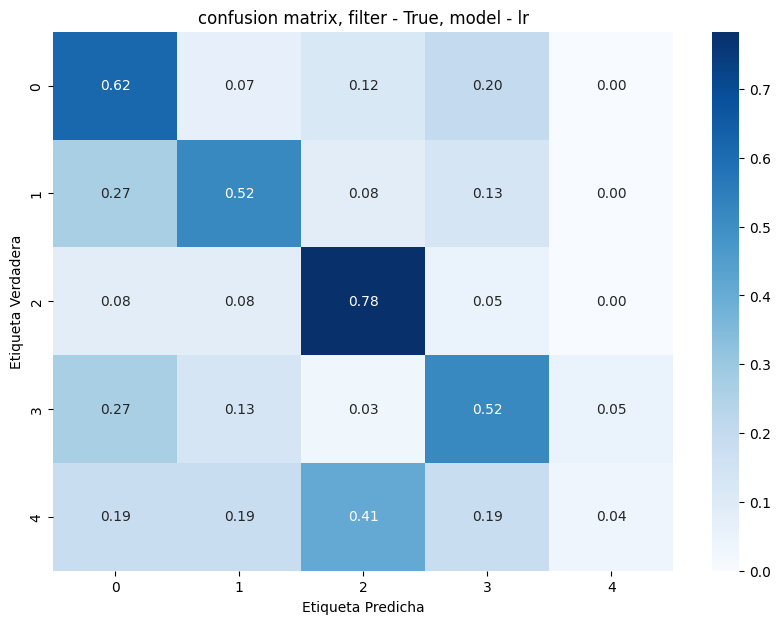

Model RandomForestClassifier() - filter: True - silence: False
Matriz de confusión normalizada
[[0.61666667 0.21666667 0.08333333 0.06666667 0.01666667]
 [0.23333333 0.58333333 0.05       0.11666667 0.01666667]
 [0.06666667 0.13333333 0.75       0.01666667 0.03333333]
 [0.05       0.05       0.01666667 0.85       0.03333333]
 [0.18518519 0.14814815 0.11111111 0.22222222 0.33333333]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_True_model_rf.png


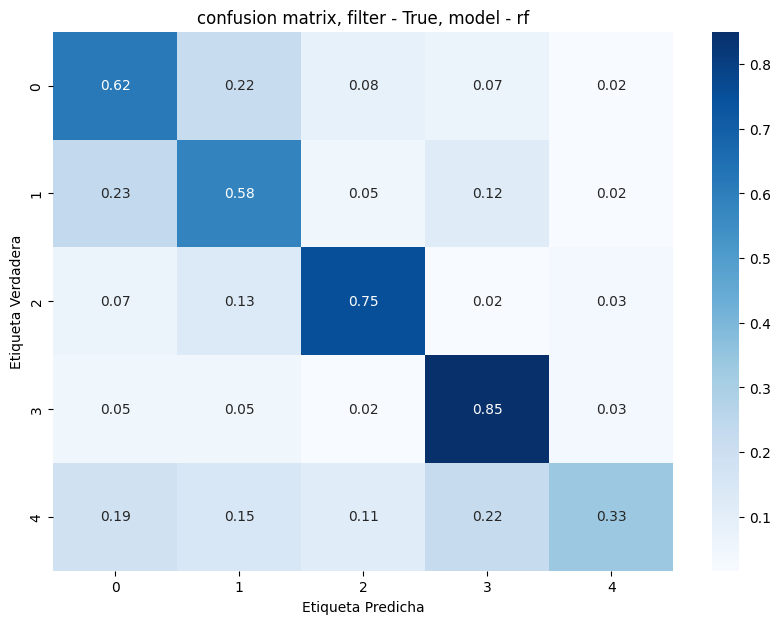

Model SVC() - filter: False - silence: False
Matriz de confusión normalizada
[[0.7        0.15       0.06666667 0.08333333 0.        ]
 [0.15       0.68333333 0.06666667 0.08333333 0.01666667]
 [0.13333333 0.1        0.73333333 0.01666667 0.01666667]
 [0.06666667 0.08333333 0.01666667 0.83333333 0.        ]
 [0.07407407 0.44444444 0.37037037 0.07407407 0.03703704]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_False_model_svc.png


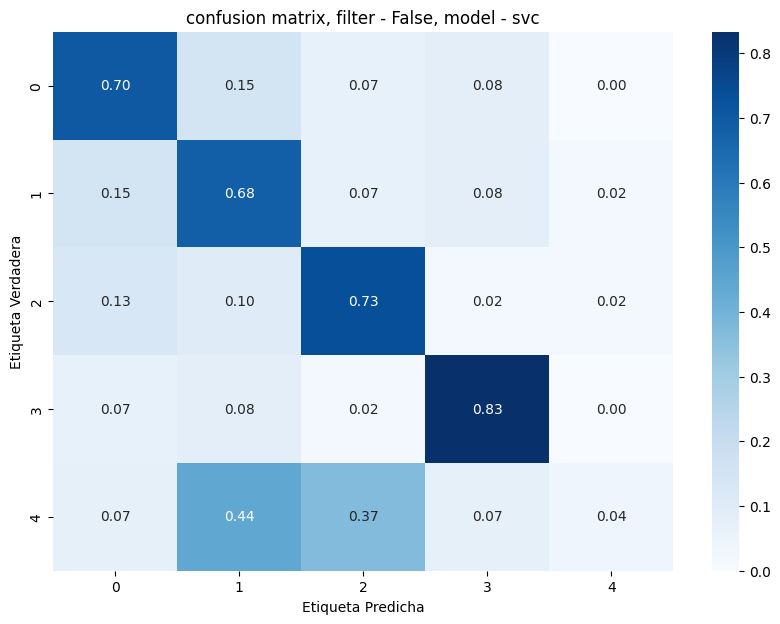

Model LogisticRegression() - filter: False - silence: False
Matriz de confusión normalizada
[[0.56666667 0.15       0.06666667 0.21666667 0.        ]
 [0.2        0.45       0.11666667 0.2        0.03333333]
 [0.1        0.06666667 0.76666667 0.05       0.01666667]
 [0.11666667 0.1        0.06666667 0.71666667 0.        ]
 [0.         0.22222222 0.59259259 0.07407407 0.11111111]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_False_model_lr.png


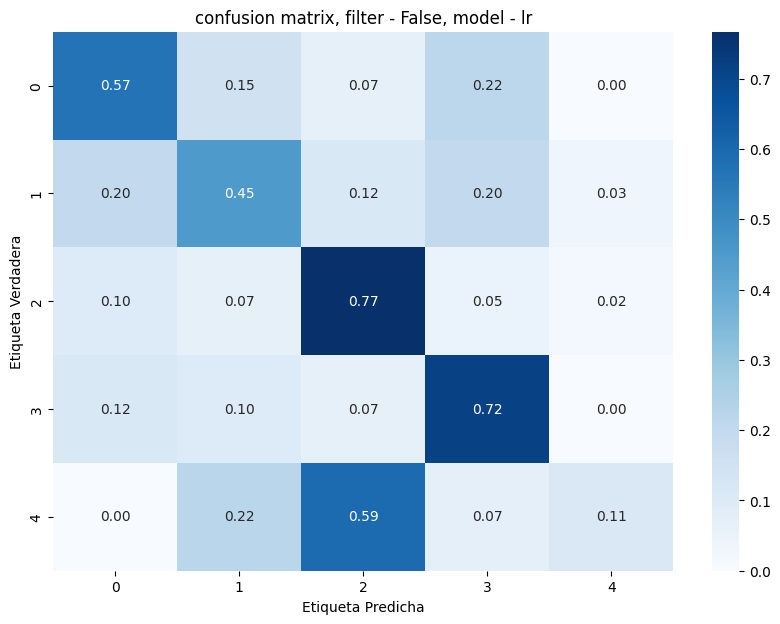

Model RandomForestClassifier() - filter: False - silence: False
Matriz de confusión normalizada
[[0.7        0.11666667 0.1        0.06666667 0.01666667]
 [0.16666667 0.66666667 0.08333333 0.05       0.03333333]
 [0.15       0.11666667 0.7        0.         0.03333333]
 [0.1        0.06666667 0.01666667 0.81666667 0.        ]
 [0.07407407 0.40740741 0.14814815 0.07407407 0.2962963 ]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/featureModel/cm/filter_False_model_rf.png


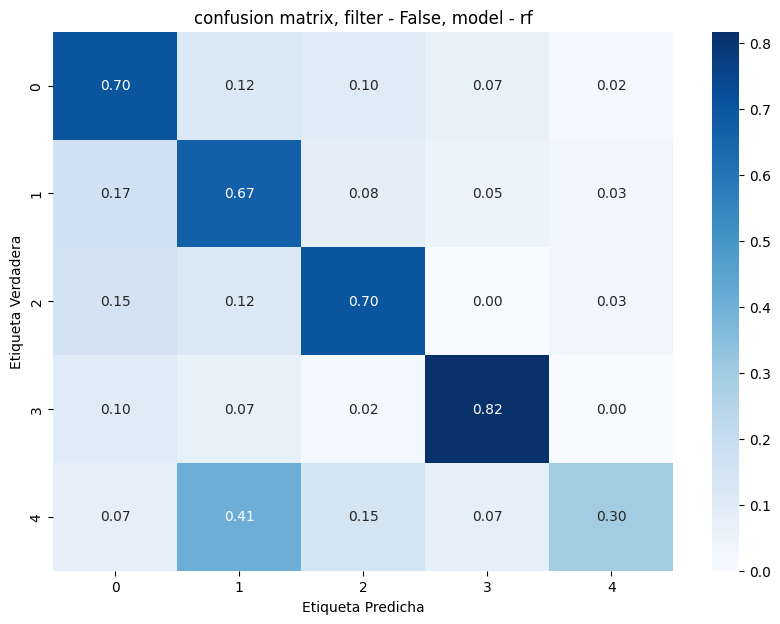

,Model,silence,filter,Accuracy,time
5,rf,False,False,0.677903,0.375026
3,svc,False,False,0.666667,0.035176
2,rf,False,True,0.662921,0.365541
0,svc,False,True,0.655431,0.044143
4,lr,False,False,0.573034,0.023041
1,lr,False,True,0.550562,0.021773


In [18]:
results_ruido_norm = backtestFeaturesModel(dataType='ruidoNorm')
results_ruido_norm = results_ruido_norm.sort_values(by='Accuracy', ascending=False)
results_ruido_norm

### Segon model utilitzant espectogrames y una petita xarxa neuronal

In [7]:
def spec(y, sr, spec = 'wavelet'):
    '''This Python function generates different types of spectrograms based on the specified type.
    
    Parameters
    ----------
    y
        The function `spec` you provided seems to be a spectrogram generator that can produce different
    types of spectrograms based on the specified `spec` parameter. However, there are a couple of issues
    in the code:
    sr
        The `sr` parameter in the `spec` function stands for the sampling rate of the audio signal. It
    represents the number of samples of audio carried per second, typically measured in Hz (Hertz).
    spec, optional
        The `spec` function you provided seems to be a spectrogram generator that can produce different
    types of spectrograms based on the `spec` parameter provided. The spectrogram types it supports are
    'wavelet', 'linear', 'log', 'mel', and 'cqt'.
    
    Returns
    -------
        the spectrogram based on the specified type of spectrogram calculation method (wavelet, linear,
    log, mel, or cqt).
    
    '''
    

    if spec == 'linear'  : spectogram = np.abs(librosa.stft(y))

    elif spec == 'log' : spectogram = np.abs(librosa.stft(y))
    
    elif spec == 'mel' : spectogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    elif spec == 'cqt' : spectogram = np.abs(librosa.cqt(y, sr=sr))
    
    elif spec == 'wavelet' : spectogram = np.abs(librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1')))
    
    else: return None
    return spectogram

In [8]:
def extrapolate_audio(y, sr, desired_duration):
    '''The function extrapolates an audio signal to a desired duration by repeating or truncating the
    original signal accordingly.
    
    Parameters
    ----------
    y
        The parameter `y` in the `extrapolate_audio` function represents the audio signal as a
    one-dimensional NumPy array.
    sr
        The `sr` parameter in the `extrapolate_audio` function stands for the sampling rate of the audio
    signal. It represents the number of samples of audio carried per second, typically measured in Hz
    (Hertz). This parameter is used to determine the duration of the audio signal and to ensure that
    desired_duration
        The `desired_duration` parameter in the `extrapolate_audio` function represents the target duration
    in seconds that you want the audio to be extrapolated or truncated to. This parameter is used to
    determine whether the input audio `y` should be repeated or truncated to match the desired duration.
    
    Returns
    -------
        The function `extrapolate_audio` returns extrapolated audio data that either repeats the input
    audio until the desired duration is reached or truncates the input audio to the desired duration.
    The function also returns the sampling rate `sr` of the audio.
    
    '''
    audio_duration = librosa.get_duration(y=y, sr=sr)
    if audio_duration < desired_duration:
        # Repeat the audio until desired duration is reached
        repetitions = int(desired_duration / audio_duration) + 1
        extrapolated_audio = np.tile(y, repetitions)[:desired_duration * sr]
    else:
        # Truncate the audio to the desired duration
        extrapolated_audio = y[:desired_duration * sr]
    return extrapolated_audio, sr


In [9]:
def compute_rowSpec(row,dataType = 'original',  specType = 'wavelet', filter = False, silence = False):
    '''This function loads an audio file, processes it to generate a spectrogram image, and optionally
    applies smoothing to the image.
    
    Parameters
    ----------
    row
        The `row` parameter in the `compute_rowSpec` function seems to be a dictionary-like object that
    contains information about an audio file, such as the file name ('Audio') and the person's ID
    ('Id_Persona'). This function loads the audio file specified in the 'Audio' field
    smooth, optional
        The `smooth` parameter in the `compute_rowSpec` function is a boolean parameter that determines
    whether to apply smoothing to the spectrogram image generated. If `smooth` is set to `True`, the
    function will apply smoothing to the spectrogram image using a specified parameter value. If
    `smooth`
    
    Returns
    -------
        The function `compute_rowSpec` returns an image representation of the audio file specified in the
    input row, along with the 'Id_Persona' value from the row. If the `smooth` parameter is set to True,
    the image is smoothed before being returned.
    
    '''
    if dataType == 'original':
        directory = 'AudiosMp3'
    elif dataType == 'ruido':
        directory = 'AudiosMp3_ruido'
    elif dataType == 'ruidoNorm':
        directory = 'AudiosMp3_norm'

    try:
        y, sr = librosa.load(f"{directory}\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"{directory}/{row['Audio']}")
    # Replace this with your feature extraction code

    if silence: y = removeSilence(y)

    y, sr = extrapolate_audio(y, sr, 6)
    
    
    if filter: y = lowPassFilter(y, sr)
        
    image = spec(y, sr, spec=specType)
    
    return image, row['Id_Persona']



In [10]:
def backtesSpecModel(dataType = 'original'):
    '''The function `backtesSpecModel` trains a convolutional neural network model on image data with
    different preprocessing options and returns the results in a DataFrame.
    
    Parameters
    ----------
    df
        The function `backtesSpecModel` takes a DataFrame `df` as input and performs a series of operations
    on it. Here is a breakdown of the steps within the function:
    
    Returns
    -------
        The function `backtesSpecModel(df)` returns a pandas DataFrame containing the results of training
    and evaluating a Convolutional Neural Network (CNN) model on the input data `df`. The DataFrame
    includes columns for the model type ('cnn'), preprocessing method (normalized or not), smooth
    parameter (True or False), accuracy of the model, and the time taken for training.
    
    '''
    results = []


    df = createDataset(dataType)
    
    for filter in [ False]:
        for silence in [ True]:
            data = df.apply(lambda row: compute_rowSpec(row, dataType=dataType, filter=filter, silence = silence), axis=1)
            
            X, y = unzipData(data)
                
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


            input_shape = X_train.shape[1:]
            print(X_train.shape)
            model = models.Sequential([
                    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_shape[0], input_shape[1], 1), padding='valid'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.Flatten(),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(5, activation='softmax')
            ])
            model.compile(optimizer= 'adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])



            if dataType == 'original':
                batch_size = 32
            elif dataType == 'ruido':
                batch_size = 128
            else:
                batch_size = 256
                
            model.fit(X_train, y_train, epochs=8, batch_size=batch_size)


            joblib.dump(model, f'./modelos/{dataType}/specsModel/modelos/cnn_specModel_filter_{str(filter)}_silence_{str(silence)}.pkl')
            y_pred = model.predict(X_test)
                
            y_pred = np.argmax(y_pred, axis=1)
                
            accuracy = accuracy_score(y_test, y_pred)
            
            plot_confusion_matrix(y_test, y_pred, title=f'confusion matrix, filter - {filter}, model - cnn', save_path=f'./modelos/{dataType}/specsModel/cm/filter_{str(filter)}_model_cnn.png')

            results.append({
                        'Model': 'cnn',
                        'filter': filter,
                        'silence': silence,
                        'Accuracy': accuracy,
                        
            })

    return pd.DataFrame(results)


(177, 128, 259)
Epoch 1/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1953 - loss: 64.9007
Epoch 2/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3767 - loss: 1.4390
Epoch 3/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6359 - loss: 1.0671
Epoch 4/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7662 - loss: 0.8624
Epoch 5/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9077 - loss: 0.5427
Epoch 6/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 993ms/step - accuracy: 0.9511 - loss: 0.3337
Epoch 7/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9697 - loss: 0.1908
Epoch 8/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9380 - loss: 0.1788
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1853f07c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a 

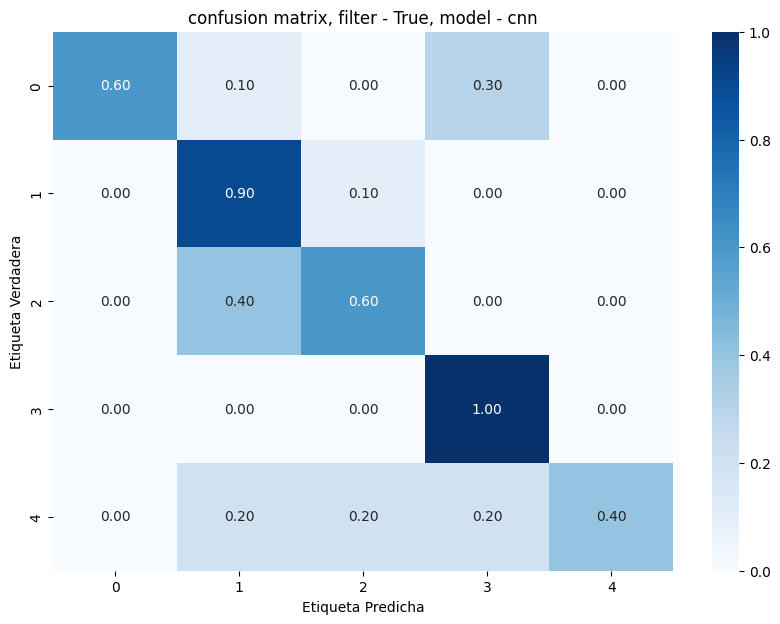

(177, 128, 259)
Epoch 1/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2622 - loss: 69.7232
Epoch 2/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 860ms/step - accuracy: 0.4482 - loss: 2.9272
Epoch 3/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7309 - loss: 1.0316
Epoch 4/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8067 - loss: 0.7839
Epoch 5/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8932 - loss: 0.5900
Epoch 6/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9539 - loss: 0.4578
Epoch 7/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9610 - loss: 0.3064
Epoch 8/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7796 - loss: 0.6531
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
Matriz de confusión normalizada
[[0.5 0.1 0.  0.4 0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.7 0.3 0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.2 0.  0.2 0.6]]
El gráfico ha sido guardado como ./modelos/original/specsModel/cm/filter_False_model_cnn.png


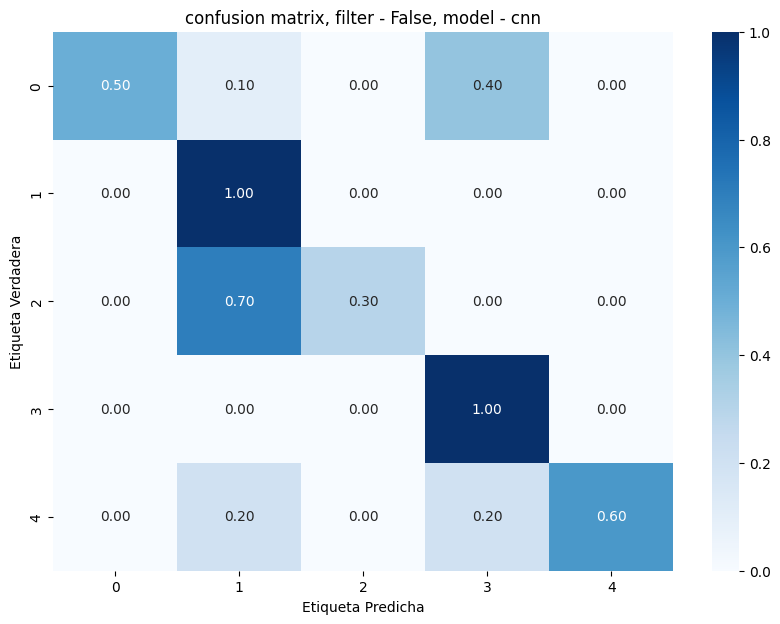

,Model,filter,silence,Accuracy
0,cnn,True,True,0.733333
1,cnn,False,True,0.688889


In [29]:
res = backtesSpecModel(dataType='original')
res = res.sort_values(by='Accuracy', ascending=False)
res

(888, 128, 259)
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.2570 - loss: 43.2993
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.3287 - loss: 1.5186
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.4278 - loss: 1.1740
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.7207 - loss: 0.8348
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.8483 - loss: 0.5559
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8666 - loss: 0.4680
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.9285 - loss: 0.2559
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.9488 - loss: 0.1595
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step
Matriz de confusión normalizada
[[0.86       0.         0.         0.12       0.02      ]
 [0.04       0.86       0.08       0.         0.02      ]
 [0.02       0.1        0.88       0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.045454

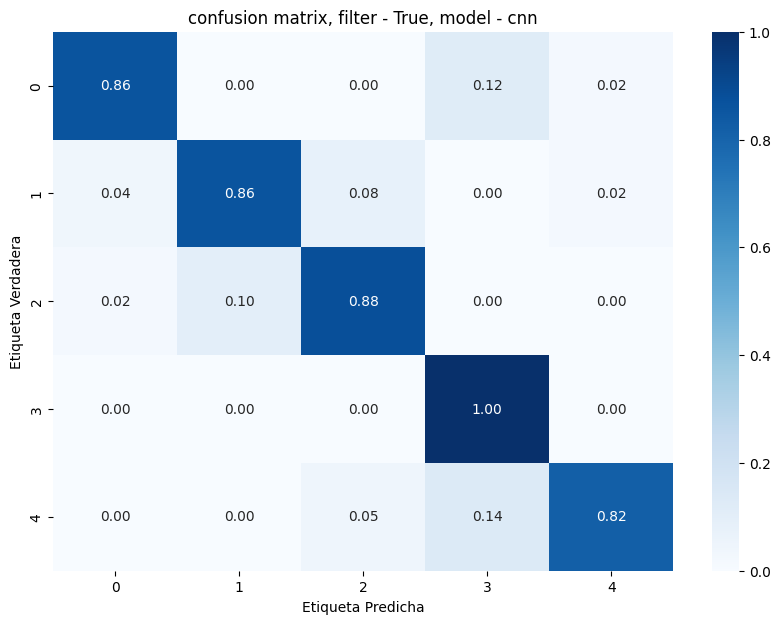

(888, 128, 259)
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.2651 - loss: 52.6550
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.2437 - loss: 1.5149
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - accuracy: 0.2398 - loss: 1.5164
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.2248 - loss: 1.5087
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.3053 - loss: 1.4595
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.3777 - loss: 1.4230
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - accuracy: 0.3483 - loss: 1.4109
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.3768 - loss: 1.4161
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 423ms/step
Matriz de confusión normalizada
[[0.         0.         0.9        0.04       0.06      ]
 [0.         0.         0.94       0.         0.06      ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.3        0.44       0.26      ]
 [0.         0.         0.227272

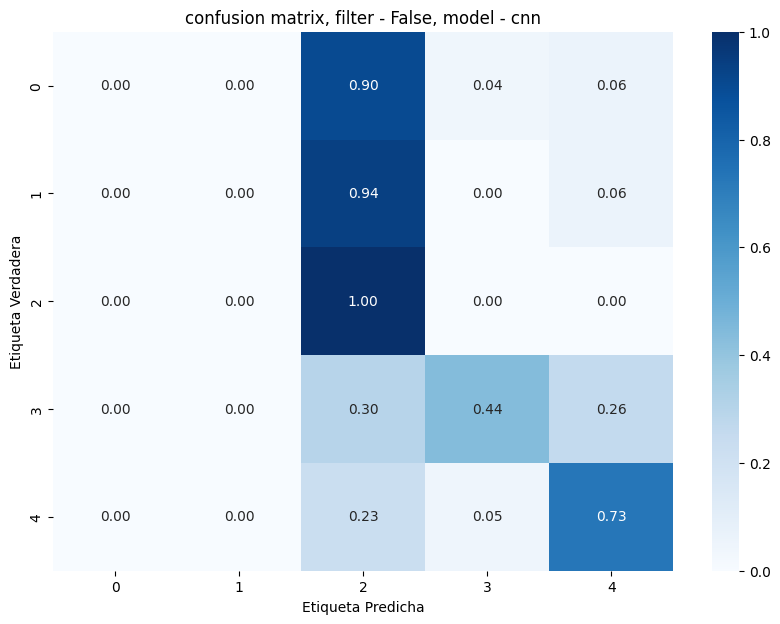

,Model,filter,silence,Accuracy
0,cnn,True,True,0.891892
1,cnn,False,True,0.396396


In [30]:
res = backtesSpecModel(dataType='ruido')
res = res.sort_values(by='Accuracy', ascending=False)
res

(1065, 128, 259)
Epoch 1/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 100s 19s/step - accuracy: 0.2241 - loss: 13.1401
Epoch 2/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - accuracy: 0.2796 - loss: 1.7711
Epoch 3/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 15s/step - accuracy: 0.5379 - loss: 1.2544
Epoch 4/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 88s 17s/step - accuracy: 0.5879 - loss: 1.0603
Epoch 5/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 16s/step - accuracy: 0.6382 - loss: 0.8440
Epoch 6/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 14s/step - accuracy: 0.8172 - loss: 0.6551
Epoch 7/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 17s/step - accuracy: 0.8637 - loss: 0.4869
Epoch 8/8
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 15s/step - accuracy: 0.9009 - loss: 0.3808
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step
Matriz de confusión normalizada
[[0.86666667 0.06666667 0.05       0.01666667 0.        ]
 [0.05       0.61666667 0.25       0.01666667 0.06666667]
 [0.01666667 0.05       0.93333333 0.         0.        ]
 [0.05       0.05       0.01666667 0.86666667 0.01666667]
 [0.         0.0740740

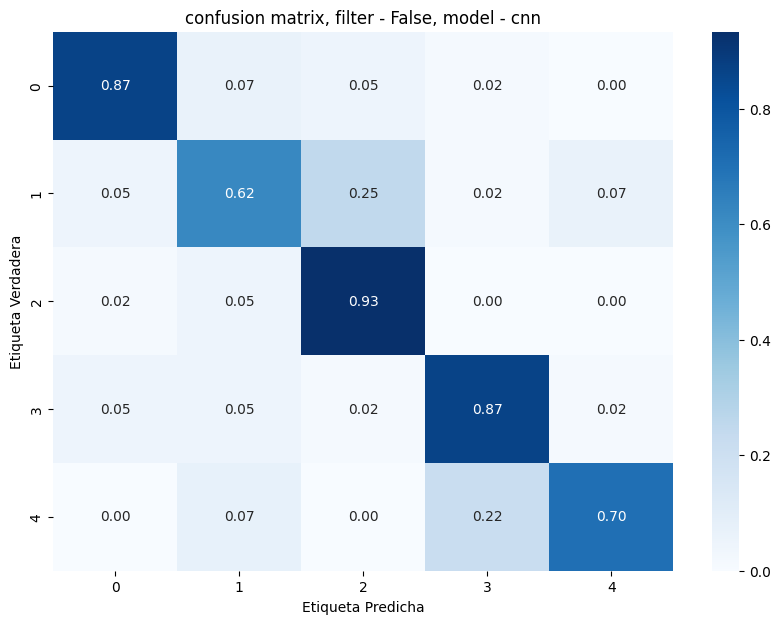

,Model,filter,silence,Accuracy
0,cnn,False,True,0.808989


In [13]:
res = backtesSpecModel(dataType='ruidoNorm')
res = res.sort_values(by='Accuracy', ascending=False)
res

### Tercer model simple (Rangs de frequencies)

In [ ]:
def slice_and_sum_frequencies(yf, range_size=50):
    '''This Python function slices a given array of frequencies into smaller ranges and calculates the sum
    of absolute values within each range.
    
    Parameters
    ----------
    yf
        The `yf` parameter seems to be a frequency array that is being sliced and processed in the
    `slice_and_sum_frequencies` function. The function slices the first 3000 elements of `yf` and then
    calculates the sum of absolute values of frequencies in each range of size `range
    range_size, optional
        The `range_size` parameter in the `slice_and_sum_frequencies` function determines the size of each
    frequency range that will be considered when summing the frequencies. By default, it is set to 50,
    meaning that the frequencies will be divided into ranges of size 50 for summation.
    
    Returns
    -------
        The function `slice_and_sum_frequencies` returns an array `summed_ranges` which contains the sum of
    absolute values of frequencies in each range of size `range_size` within the input array `yf` (up to
    the first 3000 elements of `yf`).
    
    '''
    yf = yf[:3000]
    num_freqs = 3000
    num_ranges = num_freqs // range_size
    
    summed_ranges = np.zeros(num_ranges)
    
    for i in range(num_ranges):
        freqs_in_range = yf[i * range_size: (i + 1) * range_size]
        summed_ranges[i] = np.sum(np.abs(freqs_in_range))
    
    return summed_ranges

### Primer ejemplo con frequencias agrupadas en rangos de 50

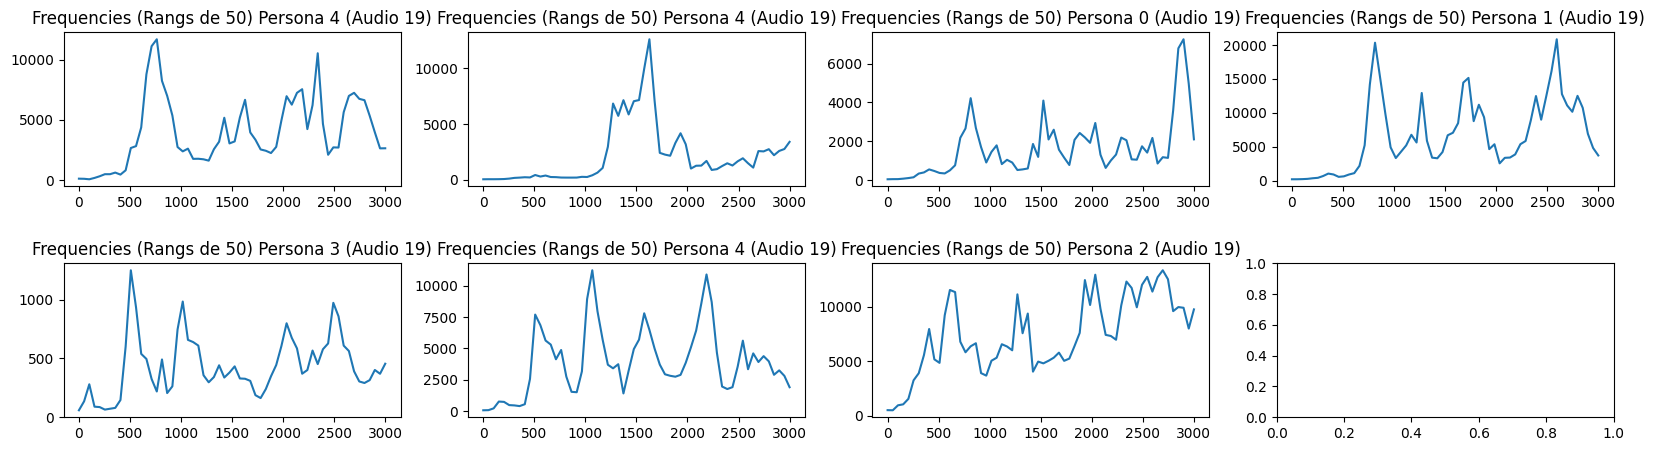

In [ ]:
def visualizeFrequencies(nAudio):
    '''The function `visualizeFrequencies` takes an audio ID, loads corresponding audio files, calculates
    FFT, and plots frequency ranges for each audio file.
    
    Parameters
    ----------
    nAudio
        It looks like the `visualizeFrequencies` function you provided is meant to visualize the
    frequencies of audio data. The function takes an argument `nAudio`, which seems to represent the
    audio ID for which you want to visualize the frequencies.
    
    '''
    rangs = np.linspace(0.0, 3000, 60)
    
    
    #yf = np.fft.fft(y)
    #xf = np.linspace(0.0, 1.0/(2.0*T), int(n/2))
    #ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))

    audios = df[df['Id_Mensaje'] == nAudio]
    audios = audios.reset_index()
    fig, ax = plt.subplots(2, int(len(audios)/2) + 1, figsize=(20, 5))
    i = 0
    j = 0
    for index, row in audios.iterrows():
      # Cargar el archivo de audio MP3
        try:
          y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
        except:
          y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")

        y = lowPassFilter(y, sr)
        
        yf = np.fft.fft(y)
        freq_ranges = slice_and_sum_frequencies(yf)
        ax[i, j].plot(rangs,freq_ranges)
        ax[i, j].set_title("Frequencies (Rangs de 50) Persona " + str(row['Id_Persona']) + " (Audio " + str(nAudio) +")")
        j = j + 1
        if j == int(len(audios)/2) + 1:
            j = 0
            i = i + 1
    plt.subplots_adjust(hspace=0.5)

visualizeFrequencies(19)



#### Creación del dataset

In [ ]:
def createDfFreq():
    '''The `createDfFreq` function processes audio files in a DataFrame to extract frequency ranges and
    adds them as new columns to the DataFrame.
    
    Returns
    -------
        The function `createDfFreq()` returns a pandas DataFrame that combines the original DataFrame `df`
    with additional columns representing frequency ranges extracted from audio files. The additional
    columns are named `freq_0`, `freq_1`, ..., `freq_n` where `n` is the number of frequency ranges
    extracted from the audio files.
    
    '''
    matriu_freq = []

    for audio_file in df['Audio']:
        try:
            y, sr = librosa.load(f"AudiosMp3\\{audio_file}")
        except:
            y, sr = librosa.load(f"AudiosMp3/{audio_file}")

        y = lowPassFilter(y, sr)
        
        yf = np.fft.fft(y)
        freq_ranges = slice_and_sum_frequencies(yf)
        matriu_freq.append(freq_ranges)

    return pd.concat([df, pd.DataFrame(matriu_freq, columns=[f'freq_{i}' for i in range(len(matriu_freq[0]))])], axis=1)

df_freq = createDfFreq()
df_freq

,Id_Mensaje,Audio,Id_Persona,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,...,freq_50,freq_51,freq_52,freq_53,freq_54,freq_55,freq_56,freq_57,freq_58,freq_59
0,33,33_Albert.mp3,1,131.206988,169.475871,364.171997,429.462183,367.967962,594.686893,547.535234,...,1692.285321,2275.526538,2444.150252,2385.155621,2608.927486,1621.699528,1472.387269,2174.972420,1706.096256,2265.526711
1,4,04_Albert.mp3,1,163.318973,254.693003,332.474084,267.396443,348.965759,1205.904313,1758.647864,...,406.071023,420.388415,528.634311,555.411889,808.102809,582.201506,677.324254,506.399260,454.762069,435.540419
2,29,29_Adria.mp3,2,97.928847,255.536177,749.578451,994.682164,1055.069892,1391.099306,1859.682202,...,599.014278,470.704182,424.674779,269.306275,490.516136,887.584486,886.483068,807.849844,1112.834930,903.187303
3,48,48_Jessi.mp3,4,40.286516,90.435394,372.499632,171.503589,347.384762,249.213970,101.674220,...,650.873085,777.910590,1292.100861,1783.976369,897.573865,998.951331,805.975080,589.690794,373.703720,652.885750
4,47,47_Adria.mp3,2,89.417378,125.637510,294.273266,178.538799,1382.427787,891.730609,2169.149428,...,3031.253860,992.906221,931.385702,2472.359718,1387.284364,2487.234601,2370.016309,1641.752255,840.045407,1354.821274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,21,21_Gerard.mp3,0,63.275331,102.743544,185.512135,383.629611,435.351054,2701.616582,4189.608681,...,190.883662,194.235375,284.537220,573.480371,618.758397,518.066707,418.928071,360.983109,464.526565,621.705523
263,43,43_PadreGerard.mp3,4,132.797806,182.415193,267.025555,3485.680229,7911.277451,7845.997315,2483.523835,...,199.231308,213.715743,235.310137,325.033228,250.349286,193.270626,203.937695,183.005234,120.542189,117.917712
264,14,14_Adria.mp3,2,289.378754,277.115505,1048.033916,1881.255088,1889.795567,3746.501353,4242.660404,...,1174.576562,1259.094379,1593.703293,2031.820454,1688.157022,1051.243391,1151.663539,1369.102843,1263.373394,975.430875
265,36,36_Raul.mp3,3,96.430944,48.760025,32.725385,482.705697,533.337548,438.298813,710.722376,...,104.954322,101.470281,60.712363,153.445374,83.525473,52.540614,46.466187,46.636447,40.808891,27.959551


In [ ]:
X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
y = df_freq['Id_Persona']

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((213, 60), (54, 60), (213,), (54,))

In [ ]:
lr = LogisticRegression(max_iter=1000, C=0.3)
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.57      0.40      0.47        10
           2       0.67      0.60      0.63        10
           3       1.00      1.00      1.00        10
           4       0.67      0.86      0.75        14

    accuracy                           0.70        54
   macro avg       0.70      0.69      0.69        54
weighted avg       0.70      0.70      0.69        54



#### Comprovar cual es el rango optimo en el que separar las frequencias

Text(0, 0.5, 'Accuracy')

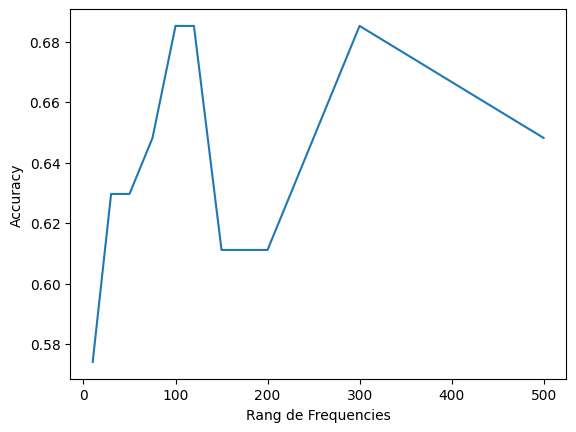

In [ ]:
def backtestRang(model='lr', smooth = True):
  '''The function `backtest_rang` performs a range of frequency analysis on audio data using logistic
  regression or random forest classifier and returns the accuracy scores and classification reports
  for different frequency ranges.
  
  Parameters
  ----------
  model, optional
    The `backtest_rang` function you provided performs a backtesting procedure for a given model
  (either logistic regression or random forest) over different frequency ranges. It calculates the
  accuracy scores and classification reports for each frequency range and returns the results.
  
  Returns
  -------
    The function `backtest_rang` returns three lists: `rangs` which contains the frequency ranges
  tested, `accuracies` which contains the accuracy scores for each frequency range, and `reports`
  which contains the classification reports for each frequency range.
  
  '''
  
  rangs = [10, 30, 50, 75, 100, 120, 150, 200, 300, 500]
  yfs = []
  accuracies = []
  reports = []

  for index, row in df.iterrows(): # Cargar el archivo de audio MP3
          try:
            y, sr = librosa.load(f"AudiosMp3\\{row['Audio']}")
          except:
            y, sr = librosa.load(f"AudiosMp3/{row['Audio']}")
            
          if smooth : y = smooth_audio(y, 3)
          
          yfs.append(np.fft.fft(y))


  for rang in rangs:
      matriu_freq = []
      for yf in yfs:
          freq_ranges = slice_and_sum_frequencies(yf, rang)
          matriu_freq.append(freq_ranges)

      df_freq = df.copy()
      for i in range(len(matriu_freq[0])):
          df_freq[f'freq_{i}'] = [matriu_freq[j][i] for j in range(len(matriu_freq))]

      X = df_freq.drop(columns=['Id_Mensaje', 'Audio', 'Id_Persona'])
      y = df_freq['Id_Persona']
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
      X_train.shape, X_test.shape, y_train.shape, y_test.shape
      
      if model == 'lr':
        m = LogisticRegression(max_iter=1000)

      elif model == 'rf':
        m = RandomForestClassifier()
        
      model = m.fit(X_train, y_train)
      y_pred = model.predict(X_test)

        
      accuracies.append(accuracy_score(y_test, y_pred))
      reports.append(classification_report(y_test, y_pred))
  return rangs, accuracies, reports
    
rangs, accuracies, reports = backtestRang('lr', smooth = True)
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')

In [ ]:
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

Millor rang de frequencies:  100
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.57      0.40      0.47        10
           2       0.58      0.70      0.64        10
           3       0.91      1.00      0.95        10
           4       0.67      0.71      0.69        14

    accuracy                           0.69        54
   macro avg       0.68      0.68      0.68        54
weighted avg       0.68      0.69      0.68        54



Millor rang de frequencies:  150
---------------------------------
---------------------------------
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.64      0.90      0.75        10
           2       0.78      0.70      0.74        10
           3       0.91      1.00      0.95        10
           4       0.88      0.50      0.64        14

    accuracy                           0.78        54
   macro avg       0.79      0.80      0.78        54
weighted avg       0.80      0.78      0.77        54



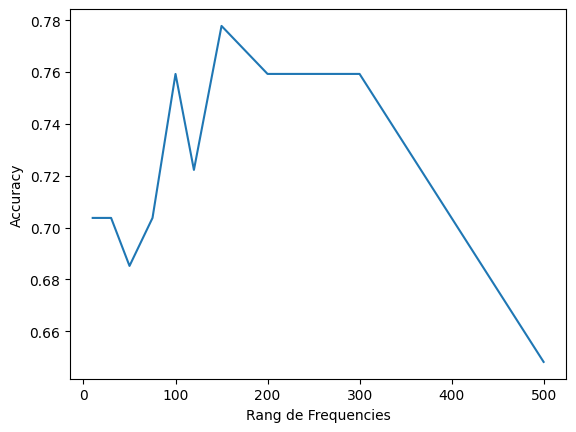

In [ ]:
rangs, accuracies, reports = backtestRang('rf')
plt.plot(rangs, accuracies)
plt.xlabel('Rang de Frequencies')
plt.ylabel('Accuracy')
millor_index = np.argmax(accuracies)
print("Millor rang de frequencies: ", rangs[millor_index])
print("---------------------------------")
print("---------------------------------")
print(reports[millor_index])

## Modelo mediante windowing o ventana deslizante para los espectogramas

In [14]:
def windowing(image, max_size, despl=0):
    '''The function `windowing` creates a matrix of windows from an input image by rearranging its columns.
    
    Parameters
    ----------
    image
        The `image` parameter is a 2D numpy array representing an image. Each element in the array
    corresponds to a pixel value in the image.
    max_size
        The `max_size` parameter in the `windowing` function represents the maximum size of the window
    matrix that will be created. This parameter determines the number of rows in the window matrix,
    while the number of columns will be the same as the number of columns in the input `image` matrix.
    
    Returns
    -------
        A matrix of windows with the same number of rows as the maximum size provided and the same number
    of columns as the input image. Each column of the matrix corresponds to a window extracted from the
    input image.
    
    '''
    
    if despl == 0 : windows = np.zeros((max_size, image.shape[0]))  # Crear matriz de ventanas con el mismo número de columnas que la imagen
    else: windows = np.zeros((max_size, image.shape[0], despl))
    for i in np.arange(0, image.shape[1]):
        if i + despl >= image.shape[1]:
            break
        if despl == 0: windows[i, :] = image[: , i]
        else: windows[ i, :, :] = image[: , i :i + despl]
    return windows


In [17]:
def compute_rowSpecWindowing(row,dataType='original',  specType='mel', despl=0, filter = False, silence = False):
    '''The function `compute_rowSpecWindowing` loads an audio file, processes it by removing silence and
    smoothing, generates a spectrogram image, and then applies windowing to create smaller segments
    along with corresponding labels.
    
    Parameters
    ----------
    row
        The `compute_rowSpecWindowing` function takes a row of data as input and processes the audio file
    specified in the row to generate spectrogram windows. Here is a breakdown of the parameters used in
    the function:
    clean, optional
        The `clean` parameter in the `compute_rowSpecWindowing` function is used to determine whether to
    remove silence from the beginning and end of the audio signal before processing it. If `clean=True`,
    the function will apply `librosa.effects.trim(y)` to remove the silence. If `
    smoothAudio, optional
        The `smoothAudio` parameter in the `compute_rowSpecWindowing` function is used to determine whether
    to apply smoothing to the audio signal before generating the spectrogram. If `smoothAudio` is set to
    `True`, the function will call a `smooth_audio` function with a smoothing factor of
    smoothSpec, optional
        The `smoothSpec` parameter in the `compute_rowSpecWindowing` function is used to determine whether
    to apply smoothing to the spectrogram image generated from the audio data. If `smoothSpec` is set to
    `True`, then the spectrogram image will be smoothed using the `smooth_image`
    
    Returns
    -------
        The code snippet is defining a function `compute_rowSpecWindowing` that processes audio data from a
    DataFrame row. It loads an audio file, trims silence if specified, applies smoothing to the audio
    and spectrogram if specified, generates a spectrogram image, and then performs windowing on the
    spectrogram image. Finally, it creates a numpy array `y` with the 'Id_Persona
    
    '''
    
    if dataType == 'original':
        directory = 'AudiosMp3'
    elif dataType == 'ruido':
        directory = 'AudiosMp3_ruido'
    elif dataType == 'ruidoNorm':
        directory = 'AudiosMp3_norm'
    try:
        y, sr = librosa.load(f"{directory}\\{row['Audio']}")
    except:
        y, sr = librosa.load(f"{directory}/{row['Audio']}")
    

    if silence : y = removeSilence(y)    
    
    
    if filter: y = lowPassFilter(y, sr)



    image = spec(y, sr, spec=specType)
        
    
    windows = windowing(image, 320, despl = despl)
    y = np.array([row['Id_Persona'] for i in range(320)])
    
    return windows, y

In [22]:
def backTestWindowing(dataType = 'original'):
    '''The function `backTestWindowing` evaluates different machine learning models using various
    spectrogram types and returns classification reports for each model and spectrogram type.
    
    Parameters
    ----------
    smoothAudio, optional
        The `smoothAudio` parameter in the `backTestWindowing` function is a boolean parameter that
    determines whether audio data should be smoothed before processing. If `smoothAudio` is set to
    `True`, the audio data will undergo a smoothing process before further analysis. If set to `False`,
    the
    smoothSpec, optional
        The `smoothSpec` parameter in the `backTestWindowing` function controls whether to apply smoothing
    to the audio spectrogram data before processing it further. If `smoothSpec` is set to `True`, it
    indicates that you want to apply some form of smoothing to the spectrogram data. This
    
    Returns
    -------
        The function `backTestWindowing` is returning a dictionary `classification_reports` containing
    classification reports for different models and spectrogram types. Each model is evaluated with
    different spectrogram types ('linear', 'log', 'mel', 'cqt', 'wavelet'). The classification reports
    include metrics such as precision, recall, F1-score, and support for each class.
    
    '''

    models = {
        "RandomForest": RandomForestClassifier(),
        #"GradientBoosting": GradientBoostingClassifier(),
        #"XGBoost": XGBClassifier(),
        #"LightGBM": LGBMClassifier(),
    }
    
    results = []
    df = createDataset(dataType)

    for model_name, model in models.items():
            
        for filter in [True, False]:
            for silence in [False]:
                print(f"Evaluating {model_name} with {filter, silence} ...")


                data = df.apply(lambda row: compute_rowSpecWindowing(row, dataType=dataType, specType='mel',despl=0,  filter=filter, silence=silence), axis=1)

                X, y = unzipData(data)

                X = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
                y = np.reshape(y, (y.shape[0] * y.shape[1]))

                y = y[np.mean(X, axis=1) != 0]
                X = X[np.mean(X, axis=1) != 0]

                sc =StandardScaler()

                X = sc.fit_transform(X)

                joblib.dump(sc, f'./modelos/{dataType}/windowing/scalers/scaler_windowing_{model_name}_filter_{str(filter)}.pkl')

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                model.fit(X_train, y_train)
            
                joblib.dump(model, f'./modelos/{dataType}/windowing/modelos/rf_windowing_filter_{str(filter)}.pkl')



                
                y_pred = model.predict(X_test)
                report = accuracy_score(y_test, y_pred)
                
                plot_confusion_matrix(y_test, y_pred, title=f'confusion matrix, filter - {filter}, model - cnn', save_path=f'./modelos/{dataType}/windowing/cm/filter_{str(filter)}_model_rf.png')

                results.append({
                        'Model': 'rf',
                        'filter': filter,
                        'Accuracy': report,
                        
                })

    return pd.DataFrame(results)

Evaluating RandomForest with (True, False) ...
Matriz de confusión normalizada
[[0.83074534 0.07996894 0.0621118  0.00465839 0.02251553]
 [0.06694856 0.86680761 0.04087385 0.01057082 0.01479915]
 [0.09864458 0.09111446 0.78614458 0.00225904 0.02183735]
 [0.0076555  0.00861244 0.00478469 0.97511962 0.00382775]
 [0.0872093  0.05232558 0.07994186 0.00290698 0.77761628]]
El gráfico ha sido guardado como ./modelos/original/windowing/cm/filter_True_model_rf.png


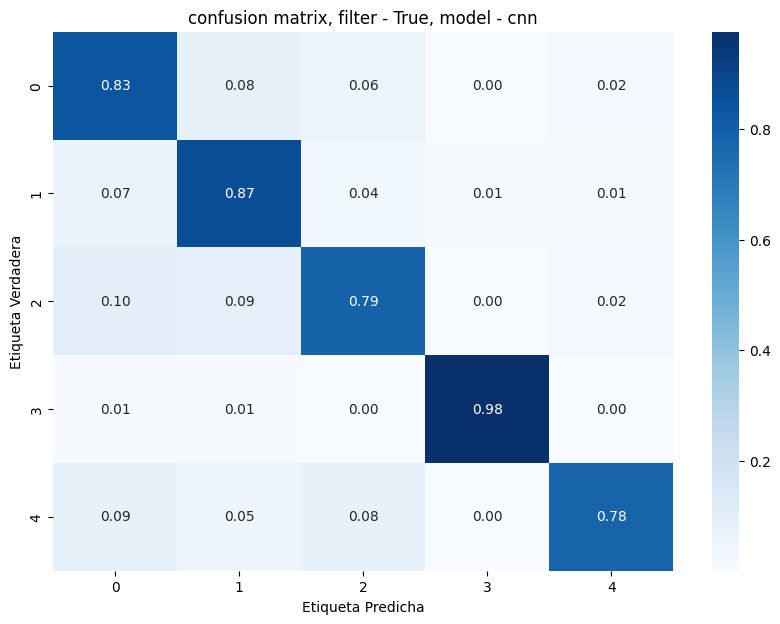

Evaluating RandomForest with (False, False) ...
Matriz de confusión normalizada
[[9.51863354e-01 6.21118012e-03 3.10559006e-02 7.76397516e-04
  1.00931677e-02]
 [7.04721635e-04 9.47145877e-01 4.36927414e-02 2.11416490e-03
  6.34249471e-03]
 [1.43072289e-02 5.42168675e-02 9.00602410e-01 6.02409639e-03
  2.48493976e-02]
 [3.82775120e-03 1.43540670e-02 1.91387560e-02 9.58851675e-01
  3.82775120e-03]
 [4.79651163e-02 4.94186047e-02 8.43023256e-02 5.81395349e-03
  8.12500000e-01]]
El gráfico ha sido guardado como ./modelos/original/windowing/cm/filter_False_model_rf.png


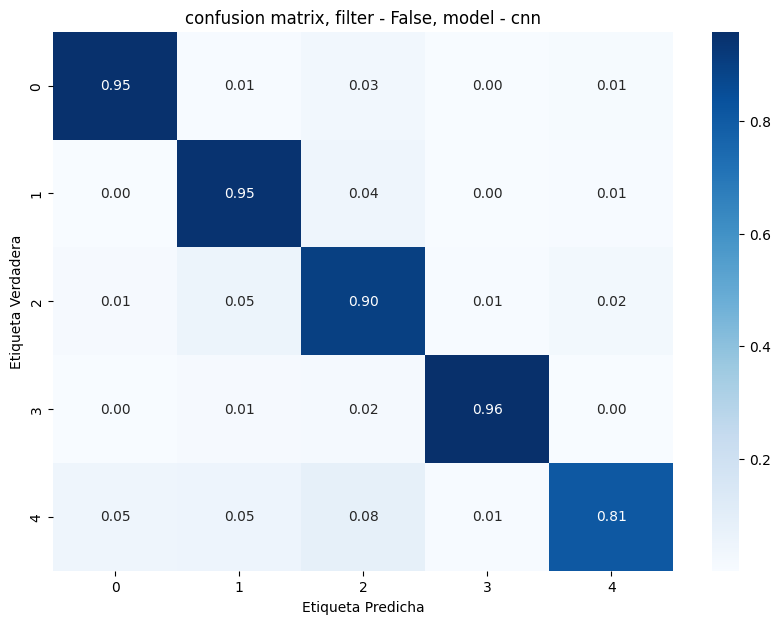

,Model,filter,Accuracy
1,rf,False,0.923544
0,rf,True,0.849168


In [20]:
reports = backTestWindowing(dataType='original')
reports = reports.sort_values(by='Accuracy', ascending=False)
reports

Evaluating RandomForest with (True, False) ...
Matriz de confusión normalizada
[[0.74347826 0.10217391 0.06413043 0.08571429 0.00450311]
 [0.08208745 0.81029619 0.04696756 0.05796897 0.00267983]
 [0.06161494 0.05739681 0.81033444 0.06794215 0.00271166]
 [0.04081633 0.03696573 0.02502888 0.89622642 0.00096265]
 [0.0697269  0.07350378 0.05636258 0.07757118 0.72283556]]
El gráfico ha sido guardado como ./modelos/ruido/windowing/cm/filter_True_model_rf.png


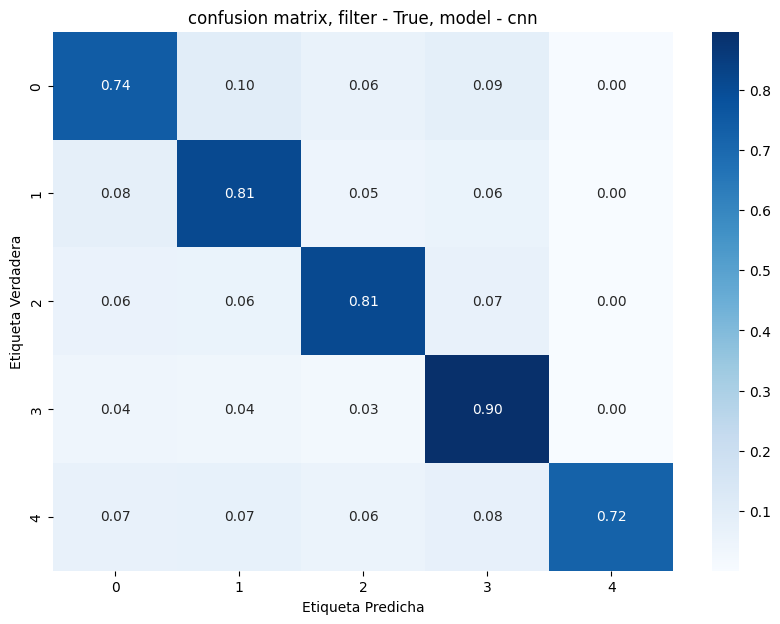

Evaluating RandomForest with (False, False) ...
Matriz de confusión normalizada
[[9.11024845e-01 3.26086957e-03 3.95962733e-02 4.47204969e-02
  1.39751553e-03]
 [7.61636107e-03 9.83779972e-01 3.38504937e-03 4.37235543e-03
  8.46262341e-04]
 [7.62277795e-02 1.43115396e-02 8.35341970e-01 7.05031636e-02
  3.61554685e-03]
 [7.52791683e-02 2.94570658e-02 2.59915287e-02 8.67731998e-01
  1.54023874e-03]
 [1.13306217e-01 2.55665311e-02 4.82277745e-02 6.27542127e-02
  7.50145264e-01]]
El gráfico ha sido guardado como ./modelos/ruido/windowing/cm/filter_False_model_rf.png


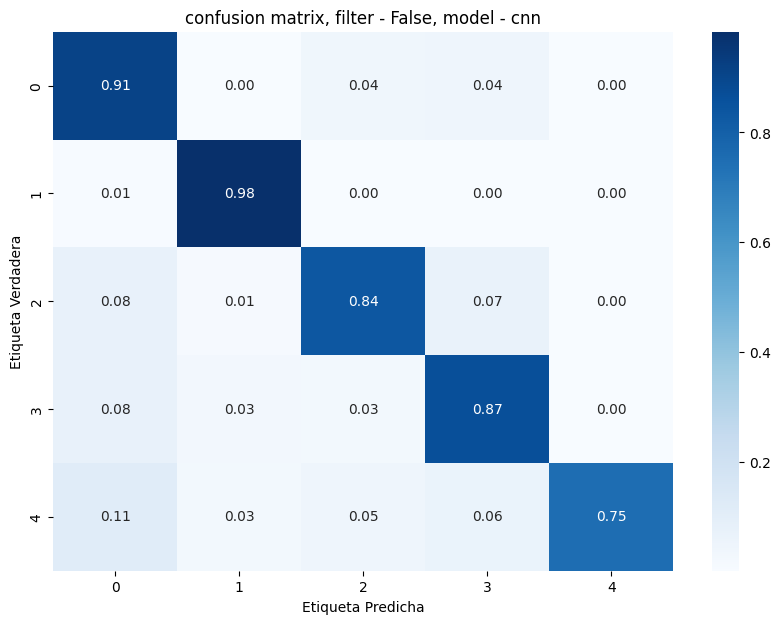

,Model,filter,Accuracy
1,rf,False,0.88446
0,rf,True,0.80041


In [23]:
reports = backTestWindowing(dataType='ruido')
reports = reports.sort_values(by='Accuracy', ascending=False)
reports

Evaluating RandomForest with (True, False) ...
Matriz de confusión normalizada
[[0.76889234 0.06534679 0.04347826 0.08268634 0.03959627]
 [0.05911388 0.85262663 0.06557762 0.01057704 0.01210483]
 [0.07607331 0.12139091 0.77717801 0.01669596 0.00866181]
 [0.11267831 0.04552012 0.02099695 0.80862318 0.01218144]
 [0.1716707  0.1220339  0.02300242 0.13317191 0.55012107]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/windowing/cm/filter_True_model_rf.png


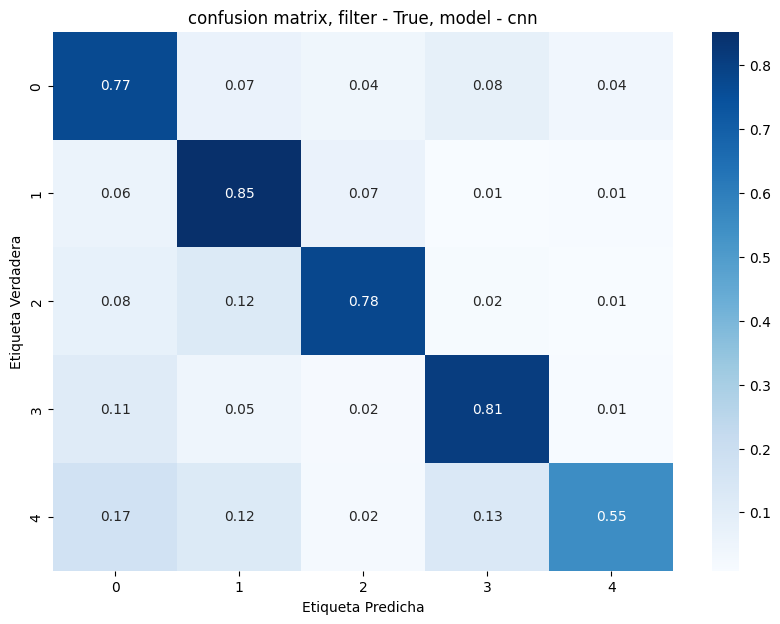

Evaluating RandomForest with (False, False) ...
Matriz de confusión normalizada
[[0.76268116 0.07039337 0.04063147 0.08876812 0.03752588]
 [0.06087672 0.84816077 0.06781055 0.01104713 0.01210483]
 [0.07619885 0.12478032 0.76324379 0.02196837 0.01380869]
 [0.11267831 0.04952717 0.02676711 0.79980766 0.01121975]
 [0.18668281 0.12615012 0.02445521 0.13099274 0.53171913]]
El gráfico ha sido guardado como ./modelos/ruidoNorm/windowing/cm/filter_False_model_rf.png


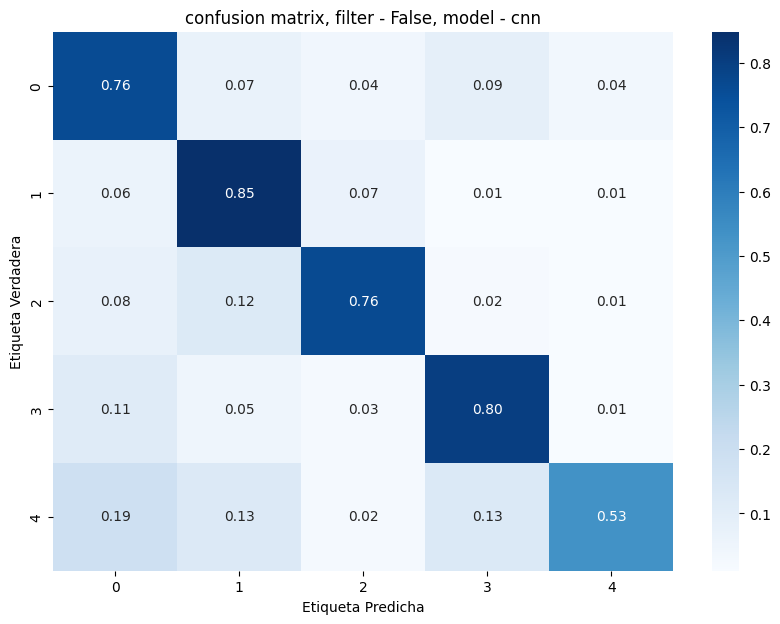

,Model,filter,Accuracy
0,rf,True,0.772446
1,rf,False,0.762958


In [24]:
reports = backTestWindowing(dataType='ruidoNorm')
reports = reports.sort_values(by='Accuracy', ascending=False)
reports

## Evaluación


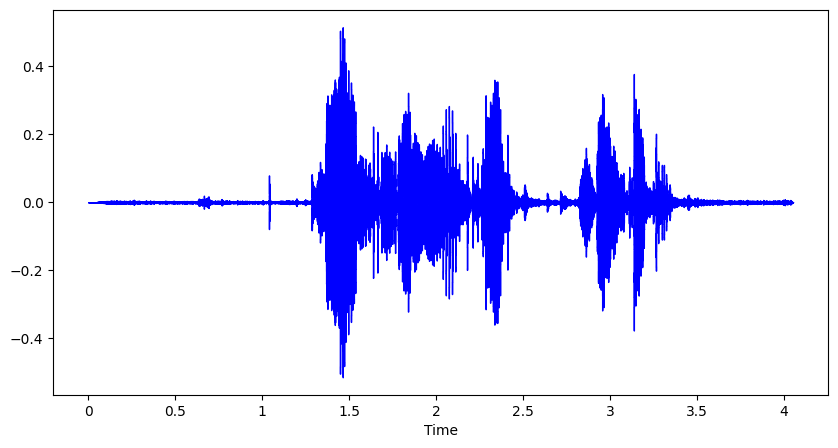

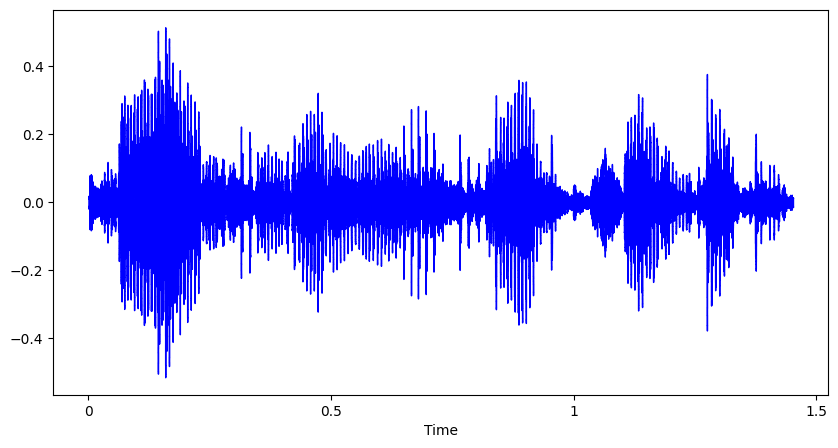

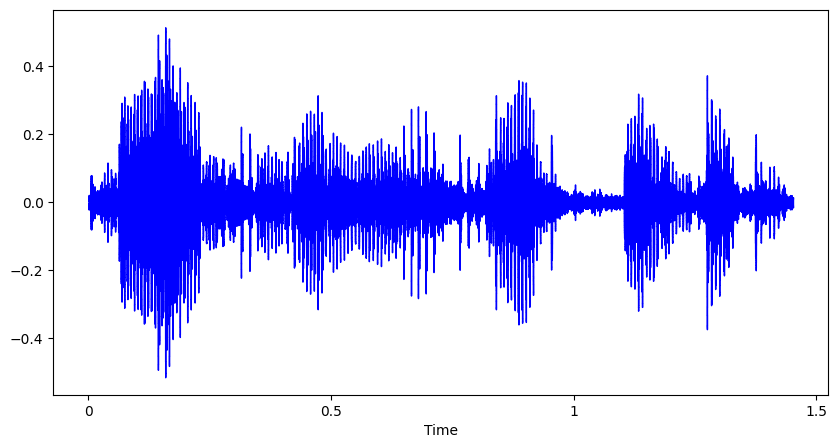

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [118]:
model = joblib.load('./modelos/ruido/featureModel/modelos/lr_featureModel_filter_True_silence_True.pkl')
scaler = joblib.load('./modelos/ruido/featureModel/scalers/scaler_featureModel_filter_True_silence_True.pkl')

y, sr = librosa.load("sientate.mp3")


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


y =removeSilence(y, 0.01)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


#y = normalize_audio(y, average_rms)
                # Aplicar filtro pasa bajos (low pass) y pasa altos (high pass)
                
y = lowPassFilter(y, sr)
#y = highPassFilter(y, sr)
                
#y = apply_compression(y)                
                        
                
                

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


features = extract_features(y, sr)

features = scaler.transform([features])

y_pred = model.predict(features)
    
                
print(f"Predicted: {y_pred}")





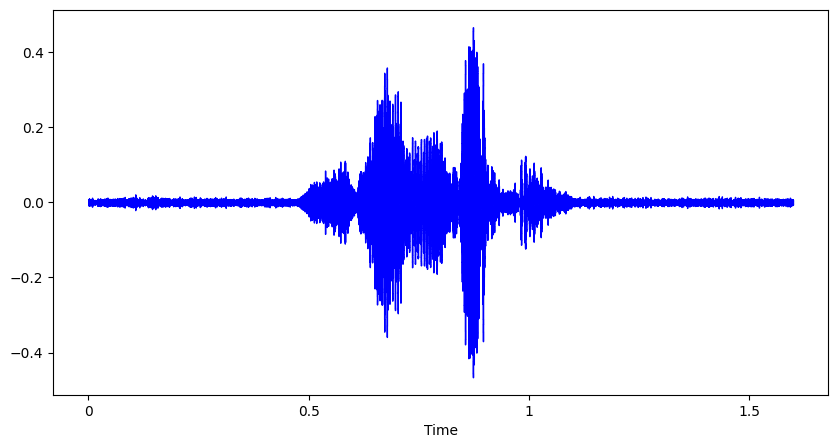

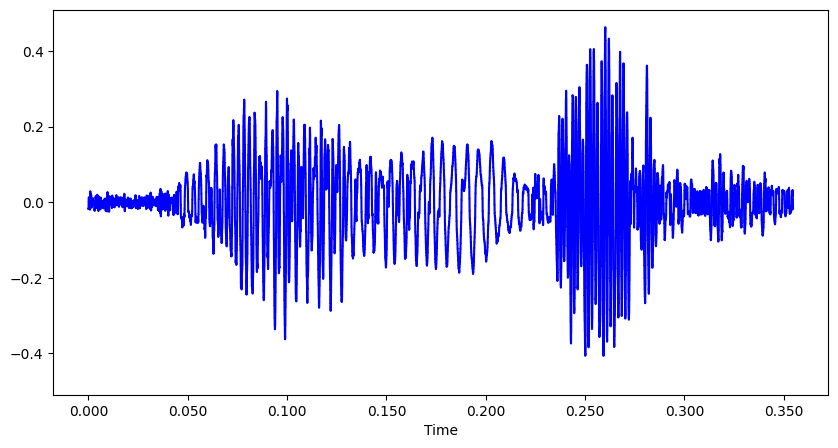

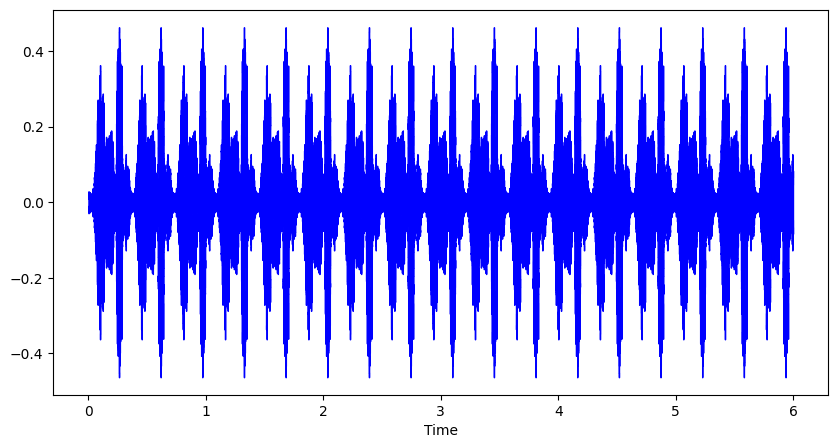

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step
Predicted: [0.20285203 0.20148939 0.20473558 0.19929843 0.1916246 ]


In [44]:
model = joblib.load('./modelos/ruido/specsModel/modelos/cnn_specModel_filter_False_silence_True.pkl')

y, sr = librosa.load("aux.mp3")


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


y = removeSilence(y, 0.02)

y = lowPassFilter(y, sr)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


#y_normalized = normalize_audio(y, average_rms)
                # Aplicar filtro pasa bajos (low pass) y pasa altos (high pass)
                
#y_lowpassed = lowPassFilter(y_normalized, sr)
#y_filtered = highPassFilter(y_lowpassed, sr)
                
#y_compressed = apply_compression(y_filtered)                
                        
                
y, sr = extrapolate_audio(y, sr, 6)
                

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


image = spec(y, sr, spec='mel')



test = np.zeros((256, image.shape[0], image.shape[1]))
test[0] = image
y_pred = model.predict(test)
                
print(f"Predicted: {y_pred[0]}")





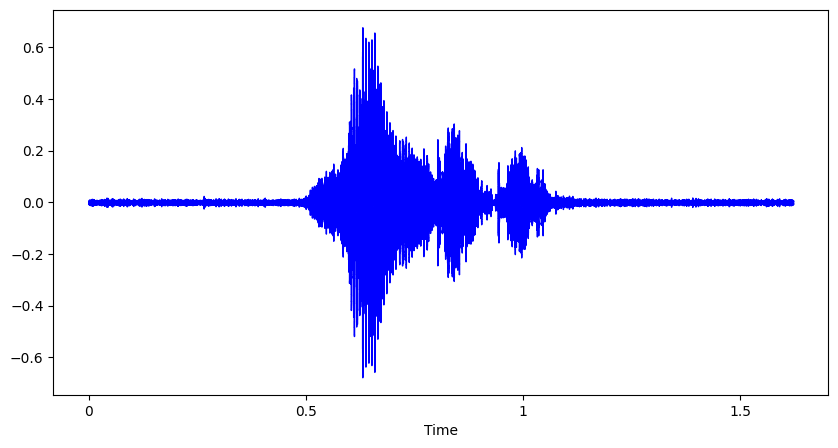

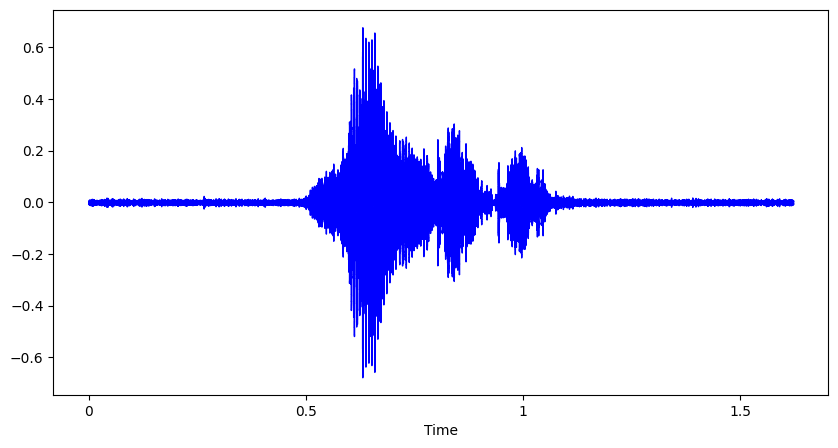

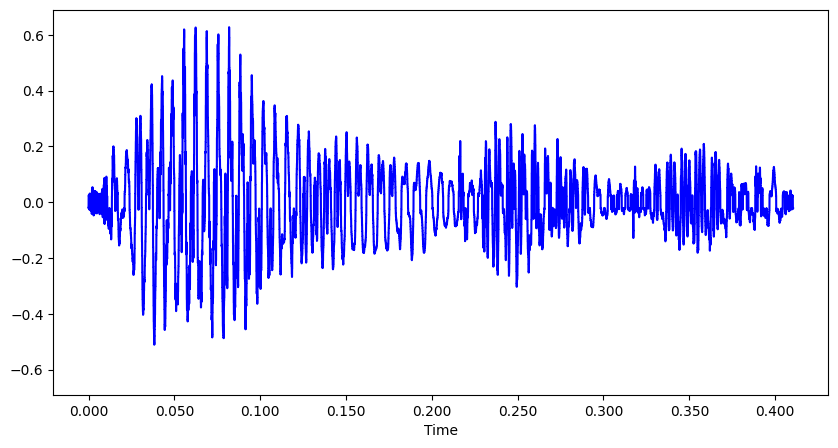

Predicted: [1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 0 2 1]


In [49]:
model = joblib.load('./modelos/ruido/windowing/modelos/rf_windowing_filter_True.pkl')
scaler = joblib.load('./modelos/ruido/windowing/scalers/scaler_windowing_RandomForest_filter_True.pkl')
y, sr = librosa.load("aux.mp3")


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


#y =removeSilence(y)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


#y_normalized = normalize_audio(y, average_rms)
                # Aplicar filtro pasa bajos (low pass) y pasa altos (high pass)




y = lowPassFilter(y, sr)

y = removeSilence(y, 0.02)
                
#y_compressed = apply_compression(y_filtered)                
                        
                
#y, sr = extrapolate_audio(y_compressed, sr, 6)
                

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
plt.show()


image = spec(y, sr, spec='mel')

windows = windowing(image, 320, despl = 0)

y = np.array([1 for i in range(320)])

y = y[np.mean(windows, axis=1) != 0]
X = windows[np.mean(windows, axis=1) != 0]


X = scaler.transform(X)


y_pred = model.predict(X)

y_pred = np.array(y_pred)


print(f"Predicted: {y_pred}")




In [50]:
import speech_recognition as sr
import numpy as np
import joblib
import librosa
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler
from io import BytesIO

model = joblib.load('./modelos/ruido/windowing/modelos/rf_windowing_filter_True.pkl')
scaler = joblib.load('./modelos/ruido/windowing/scalers/scaler_windowing_RandomForest_filter_True.pkl')


# Inicializa el micrófono y el reconocedor
microphone = sr.Microphone()
recognizer = sr.Recognizer()

with microphone as source:
    print("Calibrando para ruido ambiente...")
    recognizer.adjust_for_ambient_noise(source, duration=1)
    
    
    
    print("Calibrando para ruido ambiente...")
    
    noiseAudio = recognizer.listen(source, phrase_time_limit=3)
    noise_data = noiseAudio.get_raw_data(convert_rate=noiseAudio.sample_rate, convert_width=noiseAudio.sample_width)
    noise_segment = AudioSegment(data=noise_data, sample_width=noiseAudio.sample_width, frame_rate=noiseAudio.sample_rate, channels=1)
    noise_segment.export("noise.mp3", format="mp3")
    
    noise, sr = librosa.load("noise.mp3")
    noise, sr = extrapolate_audio(noise, sr, 6)
    
    noise = spec(noise, sr, spec='mel')
    
    print("Calibrado")

    while True:
        print("Listening...")
        audio = recognizer.listen(source, phrase_time_limit=5)
        
        try:
            print("Recognizing...")
            text = recognizer.recognize_google(audio_data=audio, language='es-ES')
            
            print(f"Recognized: {text}")
            
            if 'siéntate' in text:
                
                # Guarda los datos de audio en un archivo MP3
                raw_data = audio.get_raw_data(convert_rate=audio.sample_rate, convert_width=audio.sample_width)
                audio_segment = AudioSegment(data=raw_data, sample_width=audio.sample_width, frame_rate=audio.sample_rate, channels=1)
                

                # Exporta los datos de audio a un objeto BytesIO en formato MP3
                buffer = BytesIO()
                audio_segment.export(buffer, format="mp3")
                buffer.seek(0)

                # Carga los datos de audio desde el buffer en memoria
                
                audio_segment.export("aux.mp3", format="mp3")
                
                
                
                # Aplicar filtro pasa bajos (low pass) y pasa altos (high pass)
                
                y, sr = librosa.load(buffer, sr=None)

                
                
                y = lowPassFilter(y, sr)

                y = removeSilence(y, 0.02)
                                
                #y_compressed = apply_compression(y_filtered)                
                                        
                                
                #y, sr = extrapolate_audio(y_compressed, sr, 6)
                                

                fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                librosa.display.waveshow(y ,sr=sr, ax=ax, color="blue")
                plt.show()


                image = spec(y, sr, spec='mel')

                windows = windowing(image, 320, despl = 0)

                y = np.array([1 for i in range(320)])

                y = y[np.mean(windows, axis=1) != 0]
                X = windows[np.mean(windows, axis=1) != 0]


                X = scaler.transform(X)


                y_pred = model.predict(X)
                
                print(f"Predicted: {y_pred}")
                
                

        except Exception as e:
            print(f"Ocurrió un error: {e}")
            break



Calibrando para ruido ambiente...
Calibrando para ruido ambiente...
Calibrado
Listening...


KeyboardInterrupt: 

### Modelo complejo utilizando desplazamiento de ventana y correlaciones

#### Modelo no viable, poco optimizado muy lento 

In [ ]:
def compute_phase_correlation(spec1, spec2):
    spec1_fft = np.fft.fft2(spec1)
    spec2_fft = np.fft.fft2(spec2)

    cross_power_spectrum = spec1_fft * np.conj(spec2_fft)
    phase_correlation = np.abs(np.fft.ifft2(cross_power_spectrum))

    return phase_correlation

def predict(X_test, X_train, y_train):

    predictions = []
    for test_window in X_test:
        window_correlations = []
        for train_window in X_train:
            
            phase_correlation = compute_phase_correlation(test_window, train_window)
            window_correlations.append(np.max(phase_correlation))
            
        person_index = np.argmax(window_correlations)
        predictions.append(y_train[person_index])
    return np.array(predictions)


data = df.apply(lambda row: compute_rowSpecWindowing(row, specType='mel',despl=3, smoothAudio=True, smoothSpec=True, filter=True), axis=1)

X, y = unzipData(data)

X = np.reshape(X , (X.shape[0] * X.shape[1], X.shape[2], X.shape[3]))
y = np.reshape(y, (y.shape[0] * y.shape[1]))


y = y[np.mean(np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2])), axis = 1) != 0]
X = X[np.mean(np.reshape(X, (X.shape[0], X.shape[1]* X.shape[2])), axis = 1) != 0]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



y_pred = predict(X_test, X_train, y_train)

print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
def evaulatingModels(model = 'specsModel', dataType = 'ruido'):
    modelos = os.listdir('./modelos/{dataType}/{model}/modelos')
    for model in modelos:
        model = joblib.load(f'./modelos/{dataType}/{model}/modelos/{model}')

        if dataType == 'specsModel':

            filter = model.split('_')[3]
            silence = model.split('_')[5]
            data = df.apply(lambda row: compute_rowSpec(row, specType='wavelet', silence=silence, filter=filter), axis=1)
            
            y_pred = model.predict(X_test)
            y_pred = np.argmax(y_pred, axis=1)
        
        
        y_pred = model.predict(X_test)
        print(f"Model: {model} - {classification_report(y_test, y_pred)}")